Package Requirements:
- netCDF4
- basemap

Fishery landings data range: 1951 - 2017

# Part I - Macro Environment Indicators

In [1]:
# source http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html

import datetime as dt  # Python standard library datetime  module
import numpy as np
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

import pandas as pd 

%matplotlib inline

import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold

import statsmodels.api as sm

from pylab import *

## U.S Fishery landings data

In [2]:
# detrend function

def detrend(arr, r = 7):
    span = int(r/2)
    def helper(idx):
        scope_lst = arr[idx - span: idx + span +1]
        mean = np.mean(scope_lst)
        std = np.std(scope_lst)
        
        return (arr[idx] - mean) / std
    
    d_lst = []
    
    for i in range(span,len(arr)-3):
        d_lst.append(helper(i))
        
    return d_lst

In [3]:
# Process landing.xlsx | production data based on state and year

landings_df = pd.read_excel("data/landings.xlsx", sheet_name='Sheet1')

df = landings_df.iloc[[3, 4, 11, 16, 22]].T

df.columns = ['Year', 'ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON']

df = df[2:-1] #take the data less the header row

df.reset_index(inplace = True, drop=True)
df["AGG"] = df[['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON']].sum(axis = 1)

df.head()


,Year,ALASKA,CALIFORNIA,OREGON,WASHINGTON,AGG
0,1951,2.76588e+08,7.1927e+06,1.39074e+07,7.65346e+07,374223012.0
1,1952,2.82967e+08,7.2748e+06,1.3112e+07,4.89198e+07,352273399.0
2,1953,2.20276e+08,7.9886e+06,1.01943e+07,7.44746e+07,312933691.0
3,1954,2.47033e+08,9.4986e+06,8.8123e+06,5.93721e+07,324715557.0
4,1955,2.03675e+08,1.19796e+07,1.24709e+07,6.17543e+07,289879783.0


In [4]:
# YEAR after detrend
d_year = range(1954, 2015)

detrend_prod_df = pd.DataFrame( {"Year" : d_year, 
                            "ALASKA" : detrend(df['ALASKA']),
                            "CALIFORNIA" : detrend(df['CALIFORNIA']), 
                            "OREGON" : detrend(df['OREGON']),
                            "WASHINGTON" : detrend(df['WASHINGTON']),
                            "AGG" : detrend(df['AGG'])} )

detrend_prod_df.head()

,Year,ALASKA,CALIFORNIA,OREGON,WASHINGTON,AGG
0,1954,0.113793,0.366993,-1.732304,0.191057,0.125121
1,1955,-1.203242,1.351497,0.611638,0.638906,-0.819173
2,1956,1.382589,1.162916,1.517199,-1.697942,0.854255
3,1957,-0.368674,-0.811479,0.615749,0.056330,-0.305177
4,1958,0.546725,-1.428102,-0.305952,1.000588,0.752565


In [245]:
def prod_plot(state):
#     de_05q = detrend_prod_df[state].quantile(0.05)
#     de_95q = detrend_prod_df[state].quantile(0.95)

#     col_lst = []
#     for val in detrend_prod_df[state]:
#         color = 'red' if val < de_05q or val > de_95q else 'blue'
#         col_lst.append(color)



    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    fig.subplots_adjust(wspace=0.7, hspace=0.7)
    
    axes[0].bar(df["Year"], df[state])
    axes[1].bar(detrend_prod_df["Year"], detrend_prod_df[state])
#     axes[1].bar(detrend_prod_df["Year"], detrend_prod_df[state], color = col_lst)

#     axes[1].axhline(y=de_05q, color='r', linestyle='--')
#     axes[1].axhline(y=de_95q, color='r', linestyle='--')
    
    axes[0].title.set_text('Original')
    axes[1].title.set_text('Detrended')
#     axes[1].title.set_text('Detrended with 5th & 95th percentile')
    
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("Pounds")
    
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Pounds")

    axes[1].xaxis.set_ticks(detrend_prod_df["Year"])
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

    fig.suptitle(state)

    plt.show()

### Visualization

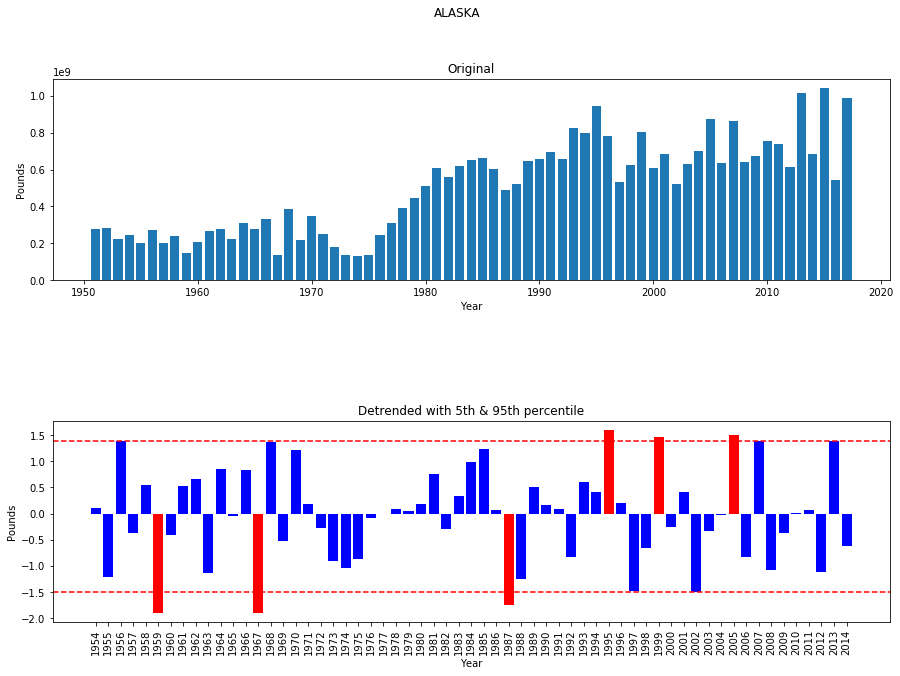

In [6]:
prod_plot("ALASKA")

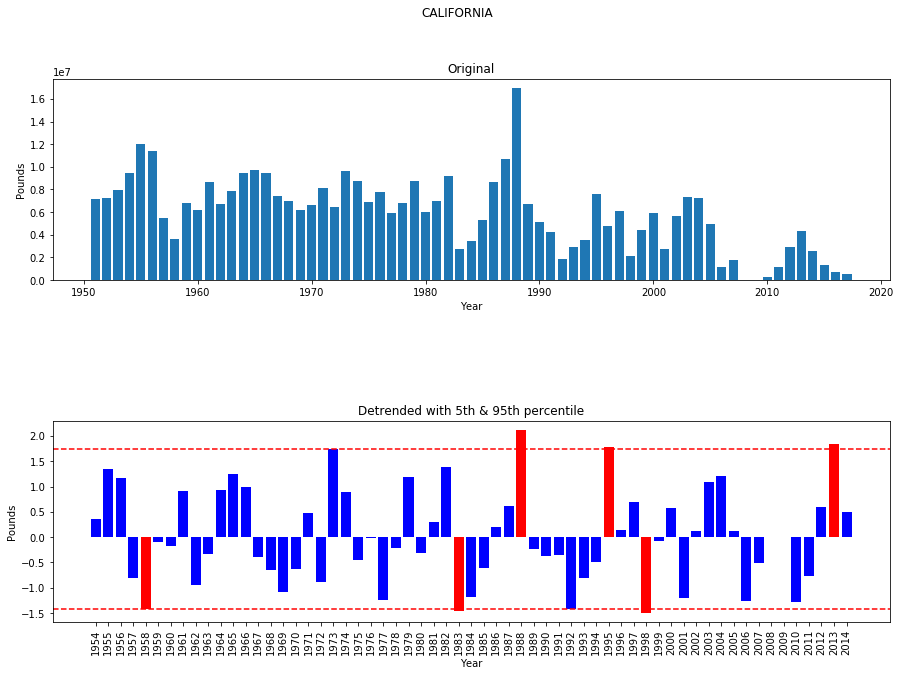

In [7]:
prod_plot("CALIFORNIA")

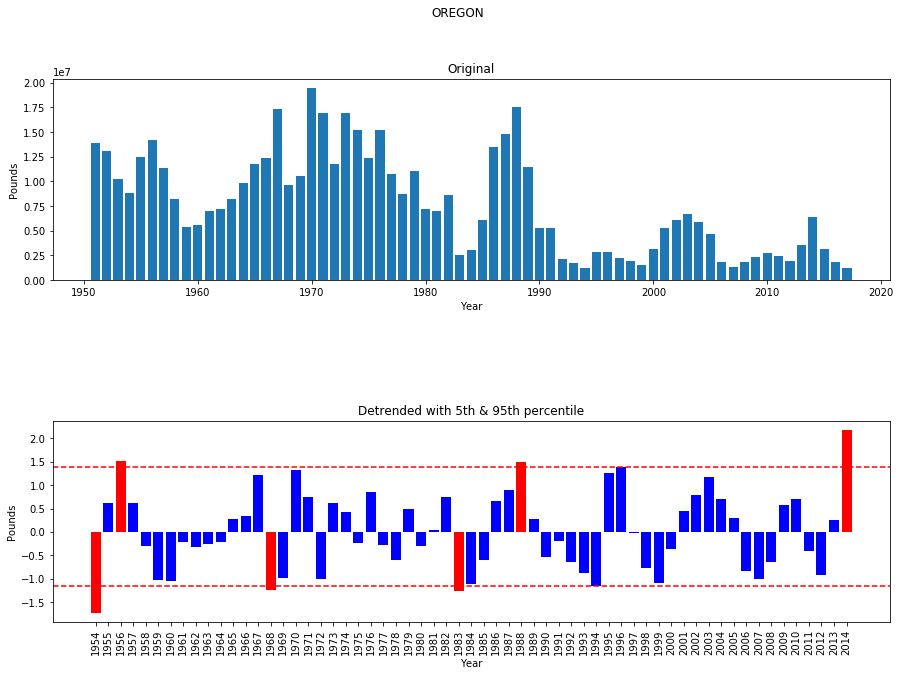

In [8]:
prod_plot("OREGON")

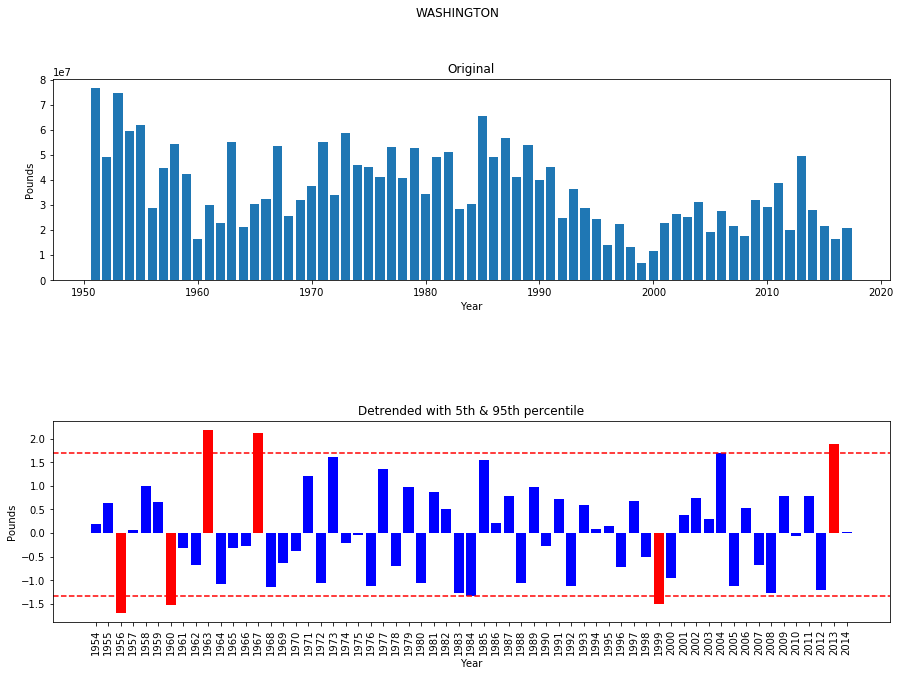

In [9]:
prod_plot("WASHINGTON")

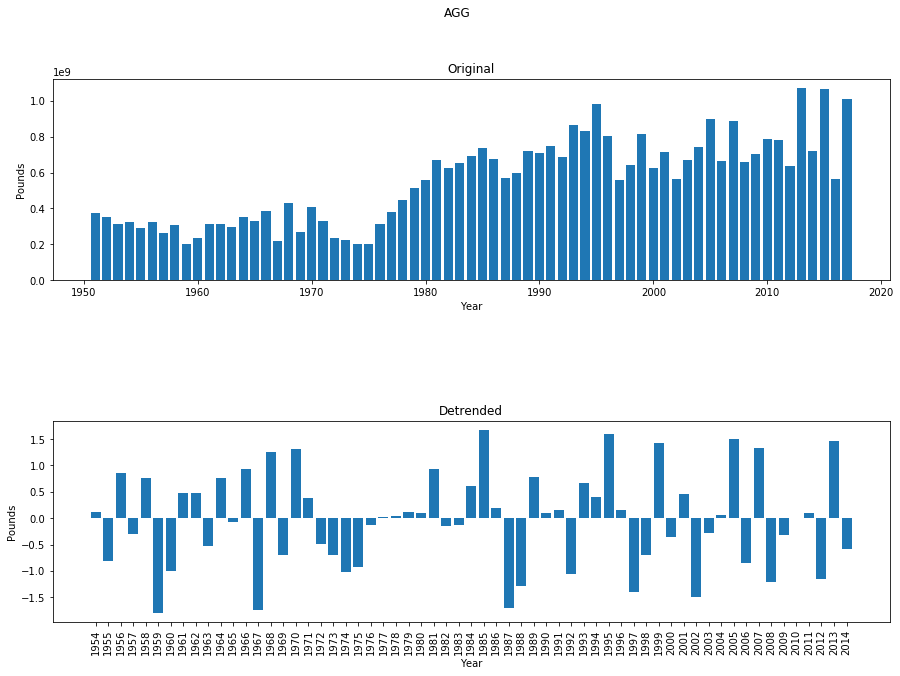

In [246]:
prod_plot("AGG")

## SEA SURFACE TEMPERATURE

#### Global Sea Surface Temperature from 1865 - 2017

In [249]:
# SST | average sea tempreature

nc_f = 'data/sst.mnmean.nc'  # Your filename
nc_fid = Dataset(nc_f, 'r', format='NETCDF4') 

 # extract/copy the data
latitude = nc_fid.variables['lat'][:] 
longitude = nc_fid.variables['lon'][:]
time = nc_fid.variables['time'][:]
sst = nc_fid.variables['sst'][:] 


# Convert time array to actual date
start = dt.date(1800, 1, 1)

# List of all times in the file as datetime objects
dt_time = [start + dt.timedelta(days=t) for t in time]


In [250]:
# Calculate yearly average sea tempreature
yearly_sst_avg_3m = []
yearly_sst_avg_12m = []

for start_idx in range(12, len(dt_time), 12):
    
    year = dt_time[start_idx].year
    # get data from Dec (last year), Jan, Feb
    
    year_sst_3m = sst[start_idx-1:start_idx+2,:,:]
    year_sst_12m = sst[start_idx:start_idx+12,:,:]
    
    month, lat_len, long_len = year_sst_3m.shape

    year_avg_3m = np.zeros([lat_len, long_len])
    year_avg_12m = np.zeros([lat_len, long_len])

    for i in range(lat_len):
        for j in range(long_len):
            year_avg_3m[i, j] = np.mean(year_sst_3m[:, i, j])
            year_avg_12m[i, j] = np.mean(year_sst_12m[:, i, j])
            
            
    yearly_sst_avg_3m.append([year, year_avg_3m])
    yearly_sst_avg_12m.append([year, yearly_sst_avg_12m])
    
yearly_sst_avg = yearly_sst_avg_3m

len_x, len_y = yearly_sst_avg[0][1].shape

/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.


In [251]:
yearly_sst_avg_scaled = []

for year, yearly_sst_data_tmp in yearly_sst_avg:
    yearly_sst_data_scaled = yearly_sst_data_tmp.copy()

    flat_year_sst = np.array([item for sublist in yearly_sst_data_tmp for item in sublist if str(item) != 'nan'])

    sst_scaler = StandardScaler()

    sst_scaler.fit(flat_year_sst.reshape(-1, 1))


    for i in range(len_x):
        for j in range(len_y):
            sst_val_tmp = yearly_sst_data_tmp[i][j]
            scaled_val_tmp = sst_scaler.transform(np.array(sst_val_tmp).reshape(-1, 1))[0][0]
            yearly_sst_data_scaled[i][j] = scaled_val_tmp
    yearly_sst_avg_scaled.append([year, yearly_sst_data_scaled])

In [257]:
use_scaled_sst = False

if use_scaled_sst:
    yearly_sst_avg = yearly_sst_avg_scaled
else:
    yearly_sst_avg = yearly_sst_avg_3m

In [253]:
def draw_with_basemap(data, title = '', color_bar = True, con_plot = True):
    # START HERE

    m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='cyl')

    # covert the latitude and longitude to raster coordinates to be plotted
    t1 = data
#     t1, lon = addcyclic(t1, longitude)
    sst_data_map, lons = shiftgrid(180., t1, longitude, start=False)
    x,y  = np.meshgrid(lons,latitude)
    px,py = m(x,y)

    # create the global map and save it as a png file
    rcParams['font.size'] = 12
    rcParams['figure.figsize'] = [8.0, 6.0]
    palette = cm.RdYlBu_r

    figure()

    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary(fill_color=(1.0,1.0,1.0))
    
    if con_plot:
        cf=m.contourf(px, py, sst_data_map, cmap = palette)
    else:
        cf=m.pcolor(px, py, sst_data_map, cmap = palette)
    if color_bar:
        cbar = colorbar(cf,orientation='horizontal', shrink=0.95)
        
    plt.title(title)

    tight_layout()
    
    plt.show()

/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


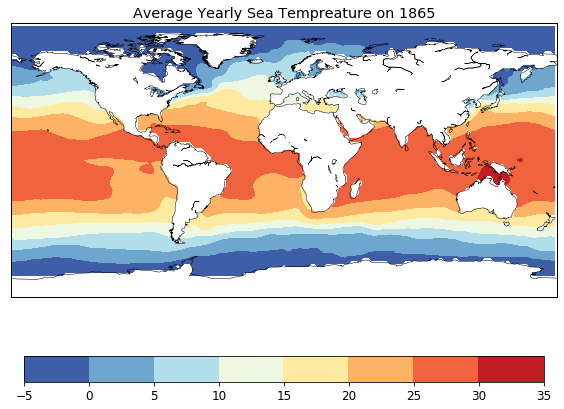

In [279]:
year_idx = 10

draw_with_basemap(yearly_sst_avg[year_idx][1], 
                  title = "Average Yearly Sea Tempreature on %d" % yearly_sst_avg[year_idx][0])

### SST comparison between high and low production years

High production years: 95th percentile  
Low production years: 5th percentile

In [254]:
def extreme_year_report(state, lower_q = 0.05, upper_q = 0.95):
    de_lower_quantile = detrend_prod_df[state].quantile(lower_q)
    de_upper_quantile = detrend_prod_df[state].quantile(upper_q)

    year_lst_lower_quantile = detrend_prod_df[detrend_prod_df[state] < de_lower_quantile]["Year"].values

    year_lst_upper_quantile = detrend_prod_df[detrend_prod_df[state] > de_upper_quantile]["Year"].values

    print(state)
    print("%dth percentile years" % int(lower_q*100))
    print(year_lst_lower_quantile)
    print("%dth percentile years" % int(upper_q*100))
    print(year_lst_upper_quantile)
    
    return [year_lst_lower_quantile, year_lst_upper_quantile]

state_lst = ['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON', 'AGG']
state_extreme_dict = {}
for state in state_lst:
    state_extreme_dict[state] = extreme_year_report(state)
    
    print("\n---\n")

ALASKA
5th percentile years
[1959 1967 1987]
95th percentile years
[1995 1999 2005]

---

CALIFORNIA
5th percentile years
[1958 1983 1998]
95th percentile years
[1988 1995 2013]

---

OREGON
5th percentile years
[1954 1968 1983]
95th percentile years
[1956 1988 2014]

---

WASHINGTON
5th percentile years
[1956 1960 1999]
95th percentile years
[1963 1967 2013]

---

AGG
5th percentile years
[1959 1967 1987]
95th percentile years
[1985 1995 2005]

---



In [255]:
def plot_extreme_year(state):
#     year_lst_lower_quantile, year_lst_upper_quantile
    year_lst_lower_quantile, year_lst_upper_quantile = state_extreme_dict[state] 

    year_sst_of_interest_lower_quantile = [d for d in yearly_sst_avg if d[0] in year_lst_lower_quantile]
    year_sst_of_interest_upper_quantile = [d for d in yearly_sst_avg if d[0] in year_lst_upper_quantile]


    # Initialize

    state_extreme_lower_quantile = np.zeros([len_x, len_y])
    state_extreme_upper_quantile = np.zeros([len_x, len_y])

    for i in range(len_x):
        for j in range(len_y):

            sst_data_lower_quantile = []
            sst_data_upper_quantile = []

            # collect sst data
            for year, data in year_sst_of_interest_lower_quantile:
                sst_data_lower_quantile.append(data[i,j])

            for year, data in year_sst_of_interest_upper_quantile:
                sst_data_upper_quantile.append(data[i,j])

            try:
                state_extreme_lower_quantile[i][j] = np.mean(sst_data_lower_quantile)
            except:
                print(i, '-', j)

            try:
                state_extreme_upper_quantile[i][j] = np.mean(sst_data_upper_quantile)
            except:
                print(i, '-', j)


    draw_with_basemap(state_extreme_lower_quantile, title = "%s Average of 5th percentile group" % state, con_plot = True)

    draw_with_basemap(state_extreme_upper_quantile, title = "%s Average of 95th percentile group" % state, con_plot = True)

/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


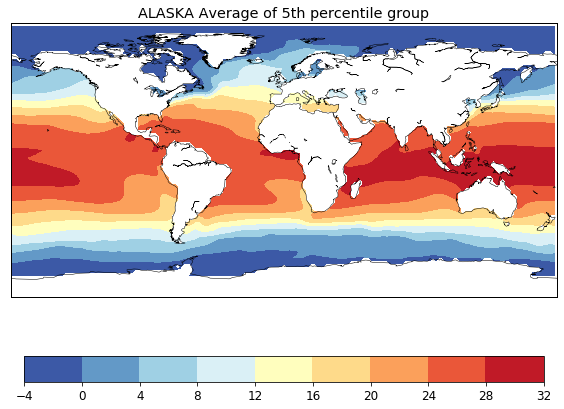

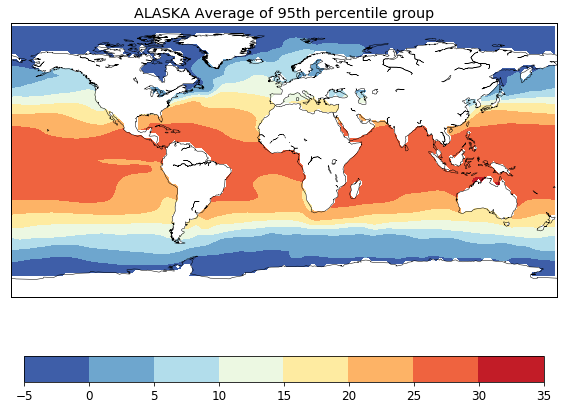

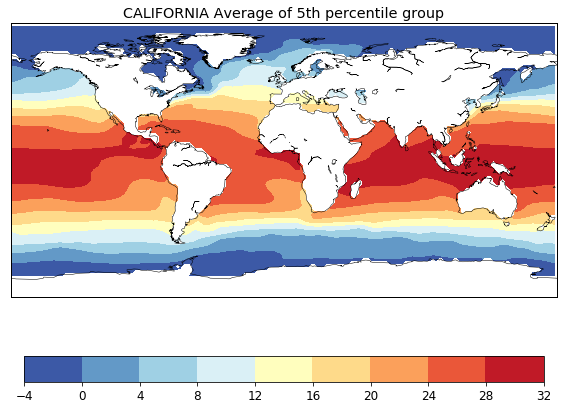

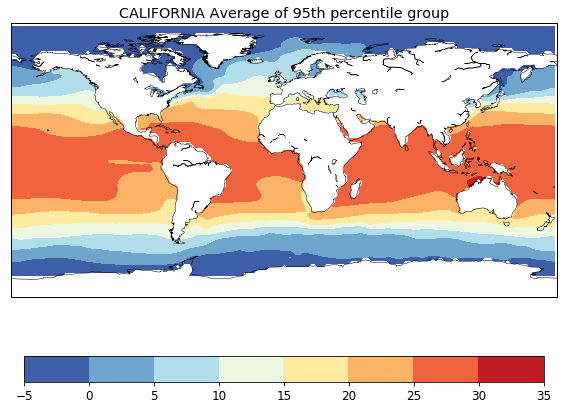

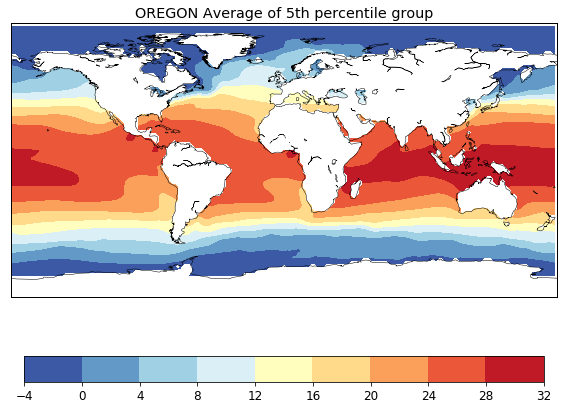

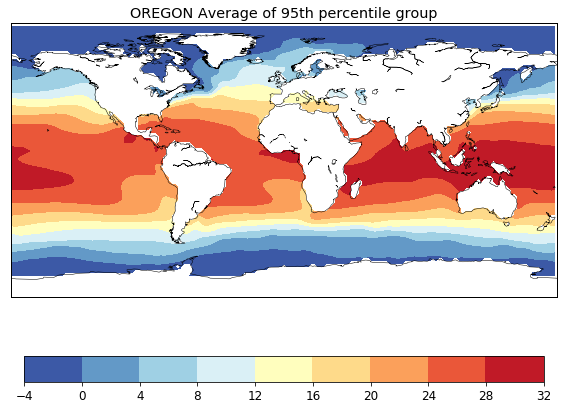

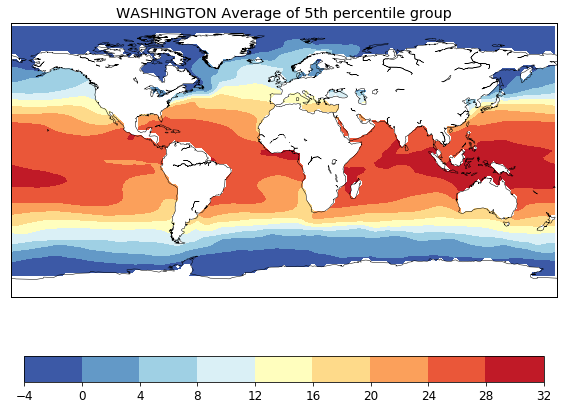

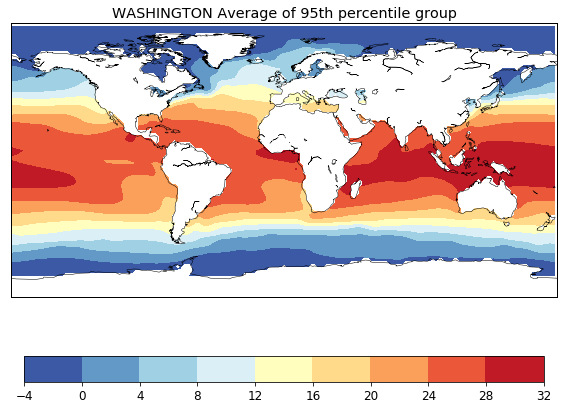

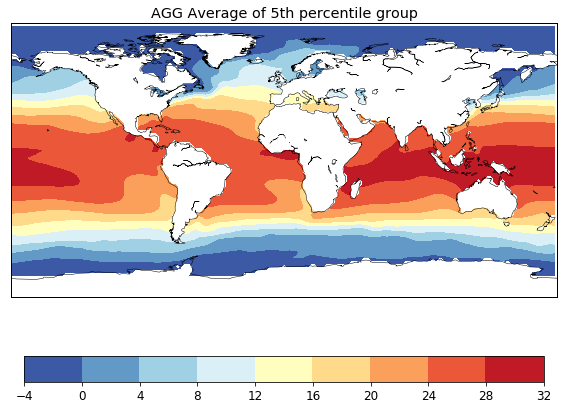

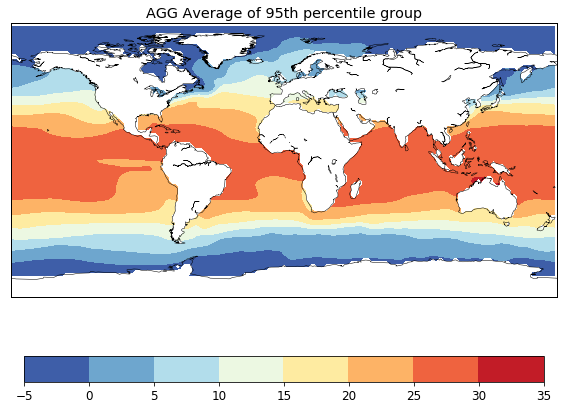

In [258]:
state_lst = ['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON', 'AGG']
for state in state_lst:
    plot_extreme_year(state)

### SST Correlation map

In [259]:
detrend_prod_df

,Year,ALASKA,CALIFORNIA,OREGON,WASHINGTON,AGG
0,1954,0.113793,0.366993,-1.732304,0.191057,0.125121
1,1955,-1.203242,1.351497,0.611638,0.638906,-0.819173
2,1956,1.382589,1.162916,1.517199,-1.697942,0.854255
3,1957,-0.368674,-0.811479,0.615749,0.056330,-0.305177
4,1958,0.546725,-1.428102,-0.305952,1.000588,0.752565
...,...,...,...,...,...,...
56,2010,0.005093,-1.276933,0.708130,-0.054198,-0.004830
57,2011,0.059814,-0.776380,-0.404101,0.790812,0.106642
58,2012,-1.116587,0.593039,-0.919121,-1.205294,-1.160376
59,2013,1.379882,1.841403,0.257179,1.893898,1.456359


In [116]:
year_lag = 1

# INPUT
yearly_sst_main = yearly_sst_avg[99-year_lag:160-year_lag]
yearly_sst_main_for_detrend = yearly_sst_avg[98-year_lag - 3:160-year_lag + 3] # detrend with 3 years

# OUTPUT
de_a = detrend_prod_df['ALASKA']
de_c = detrend_prod_df['CALIFORNIA']
de_o = detrend_prod_df['OREGON']
de_w = detrend_prod_df['WASHINGTON']
de_agg = detrend_prod_df['AGG']

input_year_min, input_year_max =  yearly_sst_main[0][0], yearly_sst_main[-1][0]
output_year_min, output_year_max = min(detrend_prod_df["Year"]), max(detrend_prod_df["Year"]) 

print("INPUT Year range: %d - %d" % (yearly_sst_main[0][0], yearly_sst_main[-1][0]) )
print("OUTPUT Year range: %d - %d" % (min(detrend_prod_df["Year"]), max(detrend_prod_df["Year"]) ))

INPUT Year range: 1953 - 2013
OUTPUT Year range: 1954 - 2014


In [127]:
# Collect the sea tempreature over the year for every coordinate 
len_x, len_y = yearly_sst_main[0][1].shape

processed_sst_data = [ [{'original' : [], 'detrend' : []} for x in range(len_y) ] 
                      for y in range(len_x) ]

for i in range(len_x):
    for j in range(len_y):

        sst_data = []
        
        # original sst
        for year, data in yearly_sst_main:
            sst_data.append(data[i,j])
        
        detrend_sst_data = []
        
        # detrend sst
        for year, data in yearly_sst_main_for_detrend:
            detrend_sst_data.append(data[i,j])
        
        detrend_sst_data = detrend(sst_data)
        
        try:
            processed_sst_data[i][j] = {'original' : sst_data, 'detrend' : detrend_sst_data}
        except:
            print(i, '-', j)

In [21]:
# latitude = nc_fid.variables['lat'][:] 
# longitude = nc_fid.variables['lon'][:]
# # time = nc_fid.variables['time'][:]
# sst = nc_fid.variables['sst'][:] 

In [265]:
def plot_sst_corr_map(fish_data, yearly_sst_data = processed_sst_data, title = "", detrend_sst = False,
                      corr_tol = 0.1, p_toll = 0.9):
    print("OUTPUT production data for %s with %d-year lag" % (title, year_lag) )
    # Map 0 - not filtered 
    len_x = len(yearly_sst_data)
    len_y = len(yearly_sst_data[0])

    corr_mat = np.zeros([len_x, len_y])
    p_mat = np.zeros([len_x, len_y])
    if detrend_sst:
        fish_data = fish_data[3:-3]
        
    for i in range(len_x):
        for j in range(len_y):

            tmp_data = []
            
            # detrend sst
            if detrend_sst:
                sst_data = yearly_sst_data[i][j]['detrend']
            else:
                sst_data = yearly_sst_data[i][j]['original'] 
            try:
                corr, p_value = pearsonr(sst_data, fish_data)
                corr_mat[i, j] = corr
                p_mat[i, j] = p_value
            except Exception as e:
                corr_mat[i, j] = np.NaN
                p_mat[i, j] = np.NaN
    
#     draw_with_basemap(corr_mat, title = 'Correlation Heat map') 
#     draw_with_basemap(p_mat, title = 'P-Value')

    # Summary data

    max_corr_pos = [0, 0]
    max_corr = -2

    min_p_pos = [0, 0]
    min_p = 10

    for i in range(len_x):
        for j in range(len_y):
            pos = [i, j]
            corr_val = abs(corr_mat[pos[0], pos[1]])
            p_val = p_mat[pos[0], pos[1]]

            if(np.isnan(corr_val) or np.isnan(p_val)):
                continue

            if corr_val > max_corr:
                max_corr_pos = pos
                max_corr = corr_val

            if p_val < min_p:
                min_p_pos = pos
                min_p = p_val
                
    
    # Map 1 - filtered data
    corr_cutoff = max_corr*(1-corr_tol)
    p_cutoff = min_p*(1+p_toll)

    corr_mat_filtered = np.zeros([len_x, len_y])
    p_mat_filtered = np.zeros([len_x, len_y])

    sig_p_index = []
    
    for i in range(len_x):
        for j in range(len_y):
            corr_val = abs(corr_mat[i, j])
            p_val = p_mat[i, j]

            if(np.isnan(corr_val) or np.isnan(p_val)):
                corr_mat_filtered[i, j] =  np.NaN
                p_mat_filtered[i, j] =  np.NaN
            else:
                if corr_val < corr_cutoff:
                    corr_mat_filtered[i, j] = 0
                else:
                    corr_mat_filtered[i, j] = 30

                if p_val > 0.1: #p_cutoff:
                    p_mat_filtered[i, j] = np.NaN
                else:
                    p_mat_filtered[i, j] = 50
                    sig_p_index.append([i, j])
    
    p_mat_filtered[0, 0] = 0
    p_mat_filtered[0, 1] = 100
#     draw_with_basemap(corr_mat_filtered, title = 'Correlation Heat map (Significant Area)\nArea with high correlation - max_corr: %.3f' % max_corr, color_bar = False)
#     draw_with_basemap(p_mat_filtered, title = 'P-Value (Significant Area)\nArea with low p-value', color_bar = False)
    
    print("Max correlation is %.6f at [%d, %d] " % (max_corr, max_corr_pos[0], max_corr_pos[1]))
    print("Min p-value is %.6f at [%d, %d] " % (min_p, min_p_pos[0], min_p_pos[1]))

    
    # START HERE

    m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='cyl')

    # covert the latitude and longitude to raster coordinates to be plotted
    t1 = corr_mat
    sst_data_map1, lons = shiftgrid(180., t1, longitude, start=False)
    
    sig_p_lon = []
    sig_p_lon1 = []
    sig_p_lat = []
    # GET THE COORDINATES
    for i in range(len_x):
        for j in range(len_y):
            p_val = p_mat[i, j]
            if p_val < 0.1:
                sig_p_lon.append(longitude[j])
                sig_p_lon1.append(lons[j])
                sig_p_lat.append(latitude[i])
        
                    
    t2 = p_mat_filtered
    sst_data_map2, lons123 = shiftgrid(180., t2, longitude, start=False)
    
    # map 1 
    x,y  = np.meshgrid(lons,latitude)
    px,py = m(x,y)
    
    # map 2
    sig_p_lon1 = [v - 180 for v in sig_p_lon1]
#     print(px_p)
    # create the global map and save it as a png file
    rcParams['font.size'] = 10
    rcParams['figure.figsize'] = [8.0, 6.0]
    rcParams['lines.markersize'] = 1
    palette = cm.RdYlBu_r

    figure()

    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary(fill_color=(1.0,1.0,1.0))
    

    cf = m.contourf(px, py, sst_data_map1, cmap = cm.RdYlBu_r)
    colorbar(cf,orientation='horizontal', shrink=0.95)
    
    marker_col = 'm'
    m.scatter(sig_p_lon, sig_p_lat, marker='.', color=marker_col , alpha = 0.6)
    m.scatter(sig_p_lon1, sig_p_lat, marker='.', color=marker_col , alpha = 0.6)
    
#     m.pcolormesh(px, py, sst_data_map2, cmap = 'plasma', alpha = 0.2)
    
        
    plt.title("Correlation and Significant P-val Overlay for %s" % title)

    tight_layout()
    
    plt.show()
    
# plot_sst_corr_map(detrend_prod_df['ALASKA'], title = "ALASKA")

### ALASKA

OUTPUT production data for ALASKA with 1-year lag
Max correlation is 0.422927 at [68, 141] 
Min p-value is 0.000685 at [68, 141] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


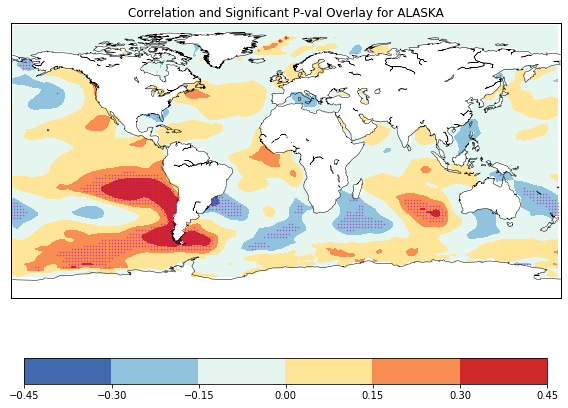

In [129]:
plot_sst_corr_map(detrend_prod_df['ALASKA'], title = "ALASKA")

### OREGON

OUTPUT production data for OREGON with 1-year lag
Max correlation is 0.352378 at [36, 21] 
Min p-value is 0.005350 at [36, 21] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


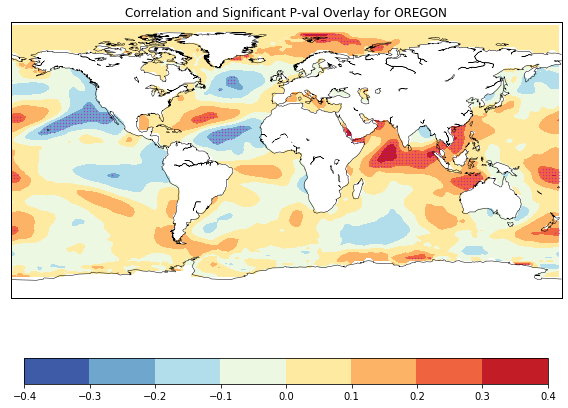

In [130]:
plot_sst_corr_map(de_o, title = "OREGON", corr_tol = 0.1, p_toll = 0.9)

### CALIFORNIA

OUTPUT production data for CALIFORNIA with 1-year lag
Max correlation is 0.446980 at [33, 146] 
Min p-value is 0.000703 at [33, 146] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


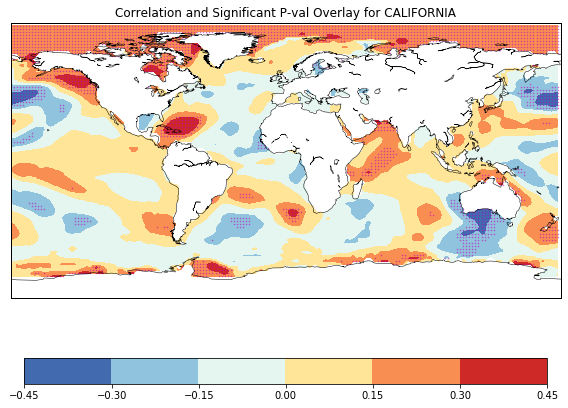

In [131]:
# cali has the last 7 years unusable due to missing data
# Collect the sea tempreature over the year for every coordinate 
len_x, len_y = yearly_sst_main[0][1].shape

processed_sst_data_cali = [ [{'original' : [], 'scaled' : [], 'detrend' : []} for x in range(len_y) ] 
                      for y in range(len_x) ]

for i in range(len_x):
    for j in range(len_y):
        processed_sst_data_cali[i][j] = {'original' : processed_sst_data[i][j]['original'][:-7], 
                                         'detrend' : processed_sst_data[i][j]['detrend'][:-7]}
        
# Washington
plot_sst_corr_map(de_c[:-7], processed_sst_data_cali,title = "CALIFORNIA")

### WASHINGTON

OUTPUT production data for WASHINGTON with 1-year lag
Max correlation is 0.339125 at [48, 5] 
Min p-value is 0.007504 at [48, 5] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


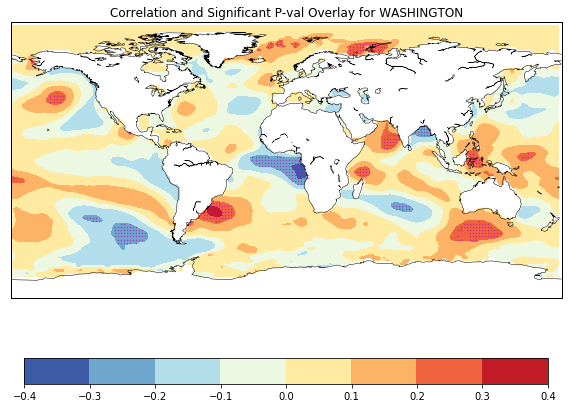

In [132]:
plot_sst_corr_map(de_w, title = "WASHINGTON")

### AGGREGATE 

OUTPUT production data for AGGREGATE with 1-year lag
Max correlation is 0.417708 at [68, 141] 
Min p-value is 0.000810 at [68, 141] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


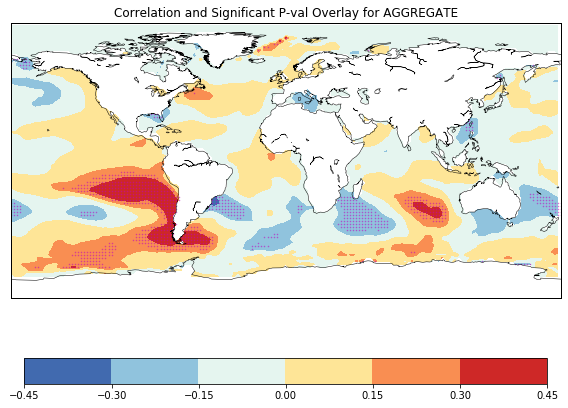

In [273]:
plot_sst_corr_map(de_agg, title = "AGGREGATE", detrend_sst = False)

In [28]:
rcParams['lines.markersize'] = 5

## ENSO Index

In [29]:
f = open("meiv2.data")
enso_idx = f.read()

enso_data = [r.split() for r in enso_idx.split('\n')]
enso_data = enso_data[0:-6]


enso_dict = {}
for i in enso_data:
    enso_dict[i[0]] = list(map(float, i[1:]))
    
    
enso_df = pd.DataFrame(enso_dict).T

enso_all = [item for sublist in enso_dict.values() for item in sublist] 

enso_year = list(enso_dict.keys())
yearly_enso_data = [np.mean(e_lst) for e_lst in enso_dict.values()]
yearly_enso_data_detrend = detrend(yearly_enso_data)

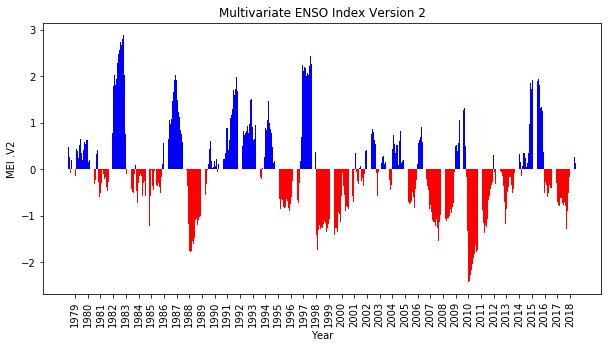

In [30]:
enso_col = ['r' if i < 0 else 'b' for i in enso_all]

plt.figure(figsize=(10, 5))

enso_len = len(enso_all)
plt.bar(range(enso_len), enso_all, color = enso_col)

plt.xlabel("Year")
plt.ylabel("MEI .V2")

plt.title("Multivariate ENSO Index Version 2")

plt.xticks(range(6,enso_len, 12), enso_year, rotation=90)

plt.show()

In [31]:
# enso yearly data as average of 3 months start at 1980
plt.figure(figsize=(10, 5))
enso_year = list(enso_dict.keys())[1:]

enso_lst = list(enso_dict.values())
yearly_enso_data = []
for i, v in enumerate(enso_lst):
    if i == 0:
        pass
    else:
        enso_year_tmp = [enso_lst[i-1][-1], v[0], v[1]]
        yearly_enso_data.append(np.mean(enso_year_tmp))
  
# yearly_enso_data_detrend = detrend(yearly_enso_data)

<Figure size 720x360 with 0 Axes>

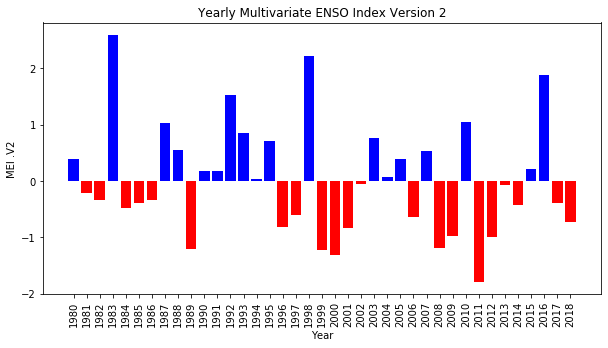

In [32]:
plt.figure(figsize=(10, 5))

enso_col_o = ['r' if v < 0 else 'b' for v in yearly_enso_data]
plt.bar(enso_year, yearly_enso_data, color = enso_col_o)

plt.xlabel("Year")
plt.ylabel("MEI .V2")

plt.title("Yearly Multivariate ENSO Index Version 2")

plt.xticks(range(len(enso_year)), enso_year, rotation=90)

plt.show()

In [302]:
enso_df = pd.DataFrame(zip(enso_year, yearly_enso_data), columns =["Year", "MEI .V2"])
enso_df['Year'] = enso_df['Year'].astype(int)

lag = 0

max_year = min(max(detrend_prod_df["Year"]), max(enso_df["Year"]))
min_year = max(min(detrend_prod_df["Year"]), min(enso_df["Year"]))

prod_year_range = [min_year+lag, max_year]
enso_year_range = [min_year, max_year-lag]

detrend_prod_df_w_lag = detrend_prod_df[ (prod_year_range[0] <= detrend_prod_df["Year"]) 
                                        & (detrend_prod_df["Year"] <= prod_year_range[1])]

enso_df_w_lag = enso_df[ (enso_year_range[0] <= enso_df["Year"]) 
                                        & (enso_df["Year"] <= enso_year_range[1])]

print("Year Range: %d - %d"%(min_year, max_year))
print("Production year range", prod_year_range)
print("Enso year range", enso_year_range)

Year Range: 1980 - 2014
Production year range [1980, 2014]
Enso year range [1980, 2014]


In [135]:
def enso_plot(state):
    plt.figure(figsize=(10,5))
    
    fish_data = detrend_prod_df_w_lag[state]
    enso_data = enso_df_w_lag['MEI .V2']

    r_sq, p_val = pearsonr(enso_data, fish_data)

    plt.scatter(enso_data, fish_data)


    plt.xlabel("MEI .V2")
    plt.ylabel("Pounds")

    plt.title("%s with lag %d \n Pearson Correlation: r_sq = %.3f p = %.3f"%(state, lag, r_sq, p_val))

    plt.show()


In [35]:
# enso_plot("ALASKA")

In [36]:
# enso_plot("OREGON")

In [136]:
max_year = 2007
min_year = max(min(detrend_prod_df["Year"]), min(enso_df["Year"]))

prod_year_range = [min_year+lag, max_year]
enso_year_range = [min_year, max_year-lag]

detrend_prod_df_w_lag_cali = detrend_prod_df[ (prod_year_range[0] <= detrend_prod_df["Year"]) 
                                        & (detrend_prod_df["Year"] <= prod_year_range[1])]

enso_df_w_lag_cali = enso_df[ (enso_year_range[0] <= enso_df["Year"]) 
                                        & (enso_df["Year"] <= enso_year_range[1])]

print("Year Range: %d - %d"%(min_year, max_year))
print("Production year range", prod_year_range)
print("Enso year range", enso_year_range)


plt.figure(figsize=(10,5))

fish_data = detrend_prod_df_w_lag_cali["CALIFORNIA"]
enso_data = enso_df_w_lag_cali['MEI .V2']

r_sq, p_val = pearsonr(enso_data, fish_data)

# plt.scatter(enso_data, fish_data)


# plt.xlabel("MEI .V2")
# plt.ylabel("Pounds")

# plt.title("%s with lag %d \n Pearson Correlation: r_sq = %.3f p = %.3f"%("CALIFORNIA", lag, r_sq, p_val))

# plt.show()


Year Range: 1980 - 2007
Production year range [1980, 2007]
Enso year range [1980, 2007]


<Figure size 720x360 with 0 Axes>

In [38]:
# enso_plot("WASHINGTON")

In [39]:
# enso_plot("AGG")

# ENSO bar plot

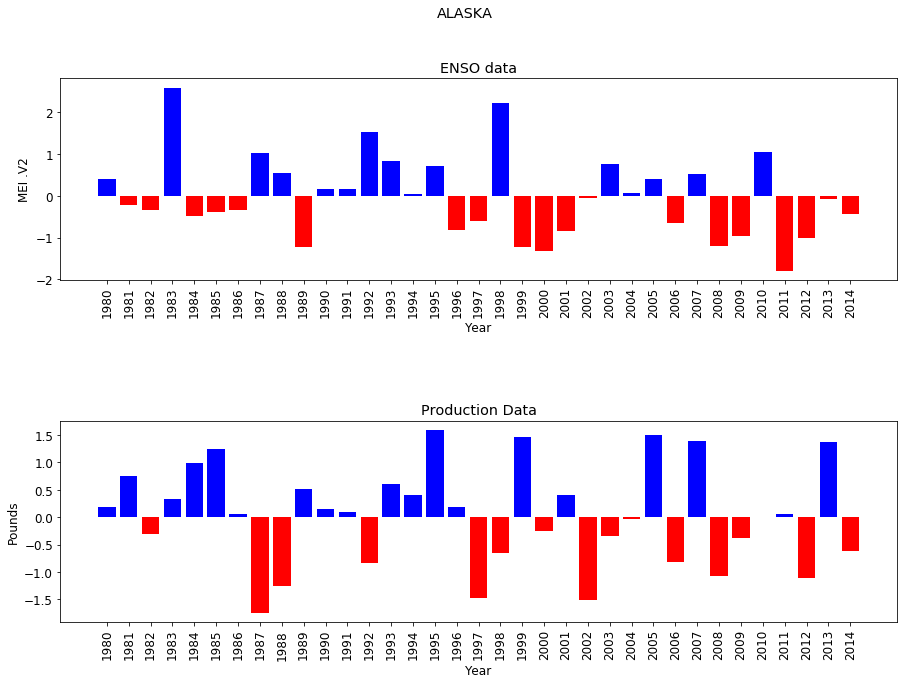

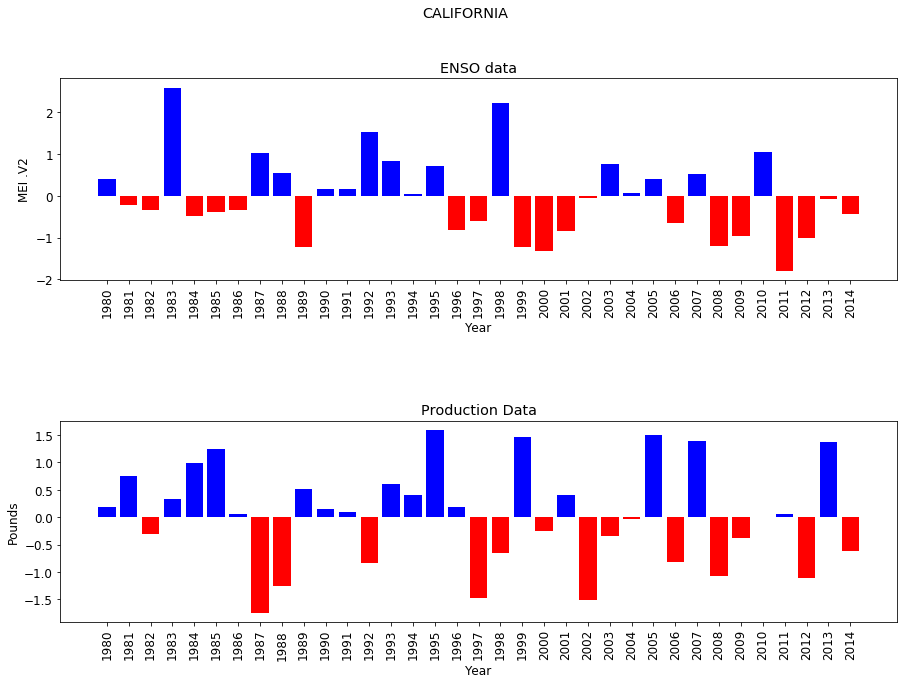

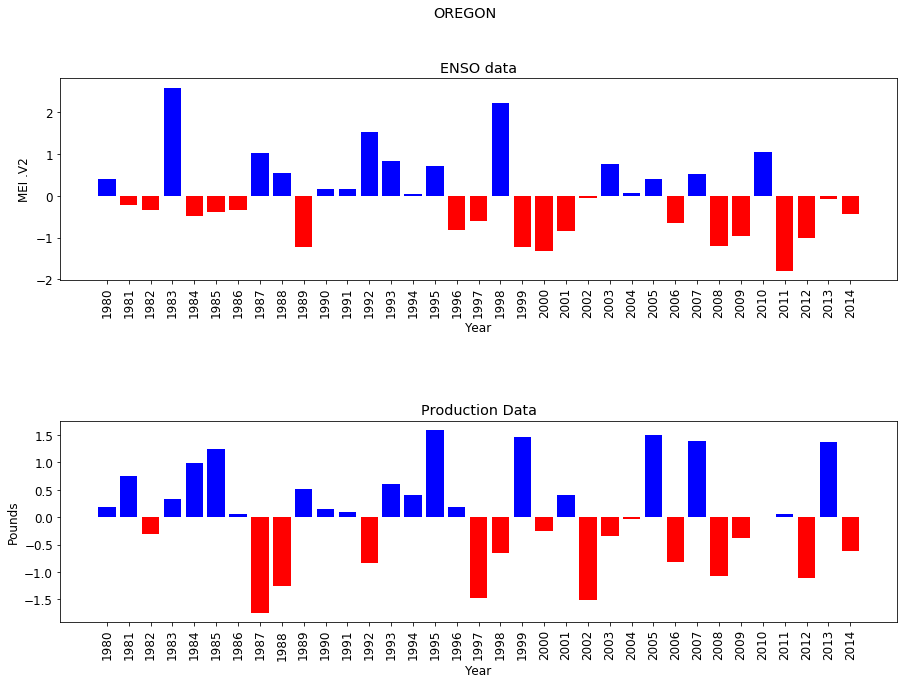

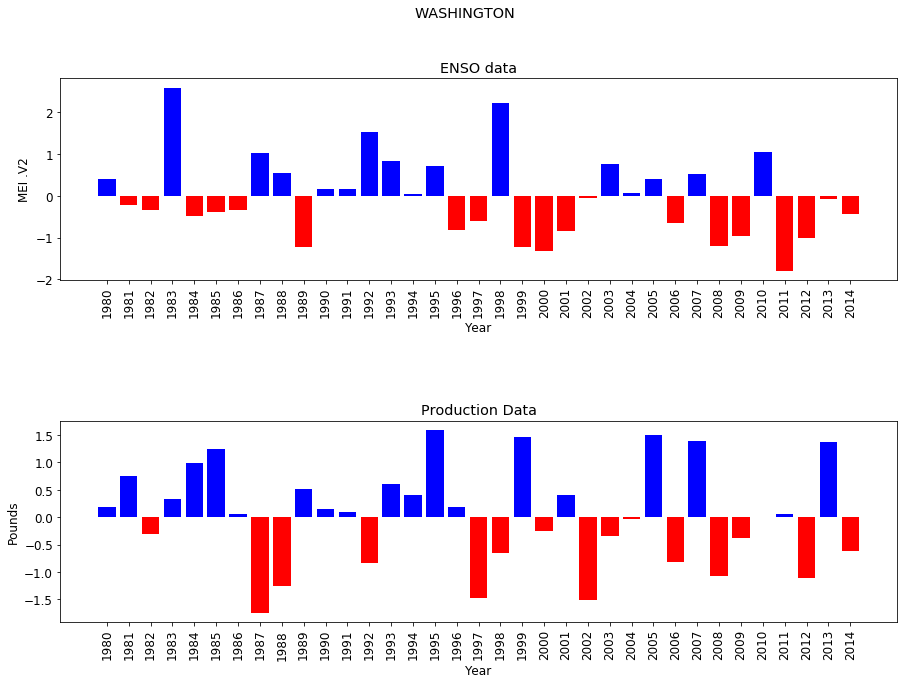

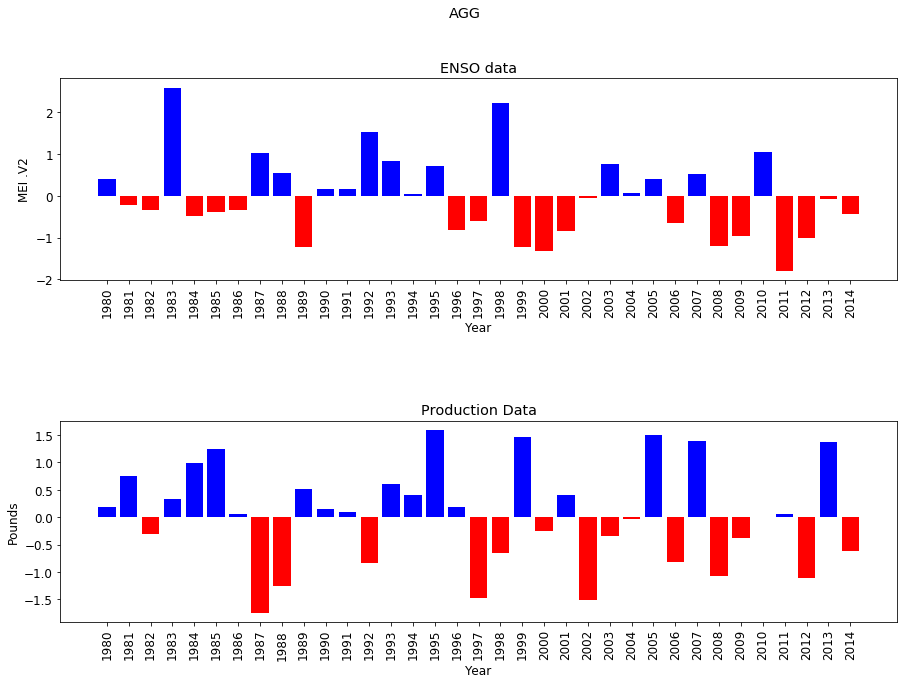

In [303]:
def enso_bar(state):
    
    fish_data = detrend_prod_df_w_lag['ALASKA'].values
    fish_year = detrend_prod_df_w_lag['Year'].values
    fish_col = ['r' if v < 0 else 'b' for v in fish_data]

    enso_data = enso_df_w_lag['MEI .V2'].values
    enso_year = enso_df_w_lag['Year'].values
    enso_col = ['r' if v < 0 else 'b' for v in enso_data]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    fig.subplots_adjust(wspace=0.7, hspace=0.7)
    
    axes[1].bar(fish_year, fish_data, color = fish_col, align='center')
    axes[0].bar(enso_year, enso_data, color = enso_col)
    
    axes[1].title.set_text('Production Data')
    axes[0].title.set_text('ENSO data')
    
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Pounds")
    
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("MEI .V2")

    axes[1].xaxis.set_ticks(fish_year)
    axes[0].xaxis.set_ticks(enso_year)
    
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)
        
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

    fig.suptitle(state)

    plt.show()
    
state_lst = ['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON', 'AGG']
for state in state_lst:
    enso_bar(state)

# Nino 3.4 & Nino 4 Index

In [41]:
f = open("data/nina34.data")
nino34 = f.read()

nino34_data = [r.split() for r in nino34.split('\n')]
nino34_data = nino34_data[3:-6]

nino34_dict = {}

for i in nino34_data:
    nino34_dict[i[0]] = list(map(float, i[1:]))

nino34_df = pd.DataFrame(nino34_dict).T

nino34_all = [item for sublist in nino34_dict.values() for item in sublist] 

nino_year = nino34_df.index

In [42]:
# f = open("data/nina4.data")
# nino4 = f.read()

# nino4_data = [r.split() for r in nino4.split('\n')]
# nino4_data = nino4_data[3:-6]

# nino4_dict = {}

# for i in nino4_data:
#     nino4_dict[i[0]] = list(map(float, i[1:]))
      
# nino4_df = pd.DataFrame(nino4_dict).T

# nino4_all = [item for sublist in nino4_dict.values() for item in sublist] 

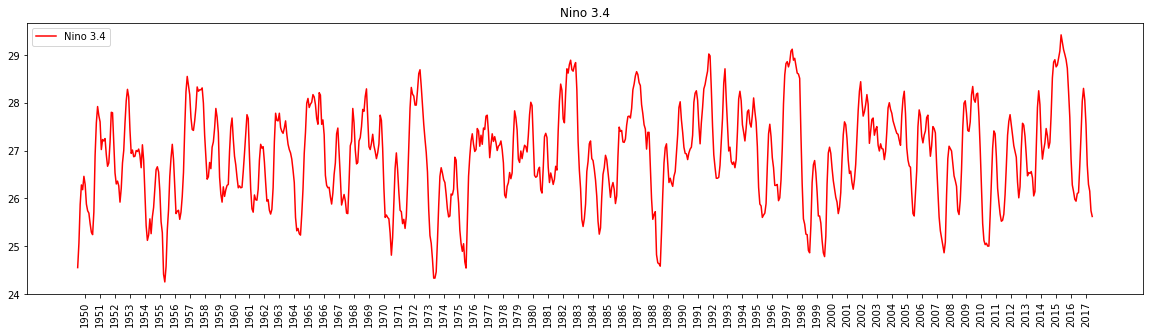

In [43]:
plt.figure(figsize=(20, 5))

plt.plot(nino34_all, label = "Nino 3.4", color ='r')
# plt.plot(nino4_all, label = "Nino 4", color ='b')


plt.title("Nino 3.4")

nino34_len = len(nino34_all)

plt.xticks(range(6,nino34_len, 12), nino_year, rotation=90)
plt.legend()
plt.show()

In [44]:
# enso yearly data as average of 3 months start at 1951
nino_year = list(nino34_dict.keys())[1:]

# nino 3.4
nino34_lst = list(nino34_dict.values())

yearly_nino34_data = []
for i, v in enumerate(nino34_lst):
    if i == 0:
        pass
    else:
        year_tmp_data = [nino34_lst[i-1][-1], v[0], v[1]]
        yearly_nino34_data.append(np.mean(year_tmp_data))
        
# yearly_nino34_data_detrend = detrend(yearly_nino34_data)

# # nino 4
# nino4_lst = list(nino4_dict.values())

# yearly_nino4_data = []
# for i, v in enumerate(nino4_lst):
#     if i == 0:
#         pass
#     else:
#         year_tmp_data = [nino4_lst[i-1][-1], v[0], v[1]]
#         yearly_nino4_data.append(np.mean(year_tmp_data))
        
# yearly_nino4_data_detrend = detrend(yearly_nino4_data)

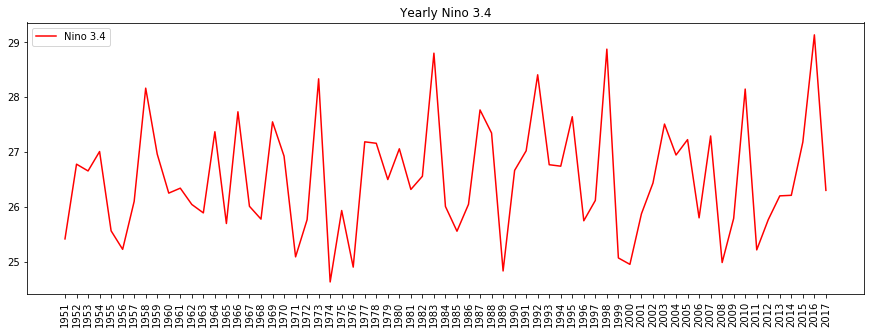

In [45]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
# fig.subplots_adjust(wspace=0.7, hspace=0.7)

# axes[0].plot(nino_year, yearly_nino4_data, color = 'b', label = "Nino 4")
# axes[1].plot(nino_year[3:-3], yearly_nino34_data_detrend, color = 'r', label = "Nino 3.4")
# axes[1].plot(nino_year[3:-3], yearly_nino4_data_detrend, color = 'b', label = "Nino 4")

# axes[0].title.set_text('Original')
# axes[1].title.set_text('Detrended')

# axes[0].legend()
# axes[1].legend()

# for tick in axes[0].get_xticklabels():
#     tick.set_rotation(90)
    
# for tick in axes[1].get_xticklabels():
#     tick.set_rotation(90)

plt.figure(figsize=(15,5))
plt.plot(nino_year, yearly_nino34_data, color = 'r', label = "Nino 3.4")

plt.legend()
plt.title("Yearly Nino 3.4")

plt.xticks(range(len(nino_year)), nino_year, rotation=90)

plt.show()

In [147]:
nino34_df = pd.DataFrame(zip(nino_year, yearly_nino34_data), columns =["Year", "Val"])
nino34_df['Year'] = nino34_df['Year'].astype(int)

nino_scaler = StandardScaler()
nino34_df["scaled_val"] = nino_scaler.fit_transform(nino34_df["Val"].values.reshape(-1, 1))

# detrend_nino4_df = pd.DataFrame(zip(nino_year[3:-3], yearly_nino4_data_detrend), columns =["Year", "Val"])
# detrend_nino4_df['Year'] = detrend_nino4_df['Year'].astype(int)


lag = 0

max_year = min(max(detrend_prod_df["Year"]), max(nino34_df["Year"]))
min_year = max(min(detrend_prod_df["Year"]), min(nino34_df["Year"]))

prod_year_range = [min_year+lag, max_year]
nino_year_range = [min_year, max_year-lag]

detrend_prod_df_w_lag = detrend_prod_df[ (prod_year_range[0] <= detrend_prod_df["Year"]) 
                                        & (detrend_prod_df["Year"] <= prod_year_range[1])]

nino34_df_w_lag = nino34_df[ (nino_year_range[0] <= nino34_df["Year"]) 
                                        & (nino34_df["Year"] <= nino_year_range[1])]

# detrend_nino4_df_w_lag = detrend_nino4_df[ (nino_year_range[0] <= detrend_nino4_df["Year"]) 
#                                         & (detrend_nino4_df["Year"] <= nino_year_range[1])]

print("Year Range: %d - %d"%(min_year, max_year))
print("Production year range", prod_year_range)
print("Nino year range", nino_year_range)

Year Range: 1954 - 2014
Production year range [1954, 2014]
Nino year range [1954, 2014]


In [148]:
def nino_plot(state, nino34 = True, use_scaled_data = True):
    plt.figure(figsize=(10,5))
    
    if use_scaled_data:
        nino34_col_name = 'scaled_val'
    else:
        nino34_col_name = 'Val'
    fish_data = detrend_prod_df_w_lag[state]
    
    nino34_data = nino34_df_w_lag["Val"]
#     nino4_data = detrend_nino4_df_w_lag["Val"] 

    r_sq34, p_val34 = pearsonr(nino34_data, fish_data)
#     r_sq4, p_val4 = pearsonr(nino4_data, fish_data)
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 13))
    fig.subplots_adjust(wspace=0.7, hspace=0.7)
    
    rcParams['lines.markersize'] = 10

    axes[0].scatter(nino34_data, fish_data)
    axes[1].scatter(nino4_data, fish_data)

    axes[0].title.set_text("Nino 3.4 | Pearson Correlation: r_sq = %.3f p = %.3f"%(r_sq34, p_val34))
    axes[1].title.set_text("Nino 4 | Pearson Correlation: r_sq = %.3f p = %.3f"%(r_sq4, p_val4))
    
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Pounds")
    
    axes[1].set_xlabel("")
    axes[1].set_ylabel("Pounds")
    
    fig.suptitle("%s with lag %d : Nino 3.4 and Nino 4" % (state, lag), fontsize=16,y=1.02)
    
    fig.tight_layout()
    plt.show()

In [149]:
# nino_plot("ALASKA")

In [49]:
# nino_plot("OREGON")

In [50]:
max_year = 2007
state = "CALIFORNIA"
min_year = max(min(detrend_prod_df["Year"]), min(nino34_df["Year"]))

prod_year_range = [min_year+lag, max_year]
nino_year_range = [min_year, max_year-lag]

detrend_prod_df_w_lag_cali = detrend_prod_df[ (prod_year_range[0] <= detrend_prod_df["Year"]) 
                                        & (detrend_prod_df["Year"] <= prod_year_range[1])]

nino34_df_w_lag_cali = nino34_df[ (nino_year_range[0] <= nino34_df["Year"]) 
                                        & (nino34_df["Year"] <= nino_year_range[1])]

# detrend_nino4_df_w_lag_cali = detrend_nino4_df[ (nino_year_range[0] <= detrend_nino4_df["Year"]) 
#                                         & (detrend_nino4_df["Year"] <= nino_year_range[1])]

    
fish_data = detrend_prod_df_w_lag_cali[state]

nino34_data = nino34_df_w_lag_cali["Val"]
# nino4_data = detrend_nino4_df_w_lag_cali["Val"] 

r_sq34, p_val34 = pearsonr(nino34_data, fish_data)
# r_sq4, p_val4 = pearsonr(nino4_data, fish_data)

# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 13))
# fig.subplots_adjust(wspace=0.7, hspace=0.7)

# axes[0].scatter(nino34_data, fish_data)
# axes[1].scatter(nino4_data, fish_data)

# axes[0].title.set_text("Nino 3.4 | Pearson Correlation: r_sq = %.3f p = %.3f"%(r_sq34, p_val34))
# axes[1].title.set_text("Nino 4 | Pearson Correlation: r_sq = %.3f p = %.3f"%(r_sq4, p_val4))

# axes[0].set_xlabel("")
# axes[0].set_ylabel("Pounds")

# axes[1].set_xlabel("")
# axes[1].set_ylabel("Pounds")

# fig.suptitle("%s with lag %d : Nino 3.4 and Nino 4" % (state, lag), fontsize=16,y=1.02)

# fig.tight_layout()
# plt.show()

In [51]:
# nino_plot("WASHINGTON")

In [52]:
# nino_plot("AGG")

# NINO bar plot

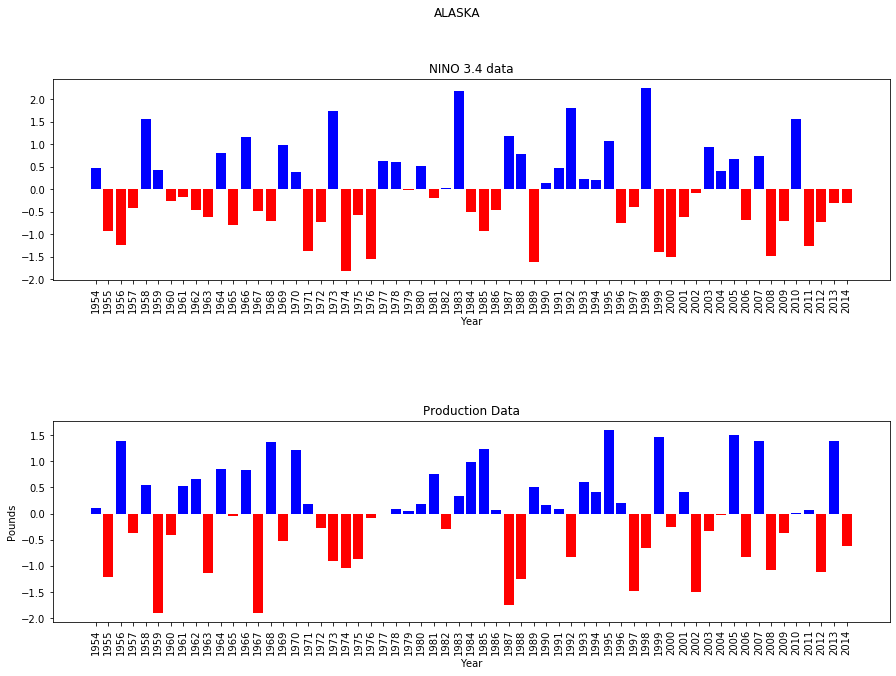

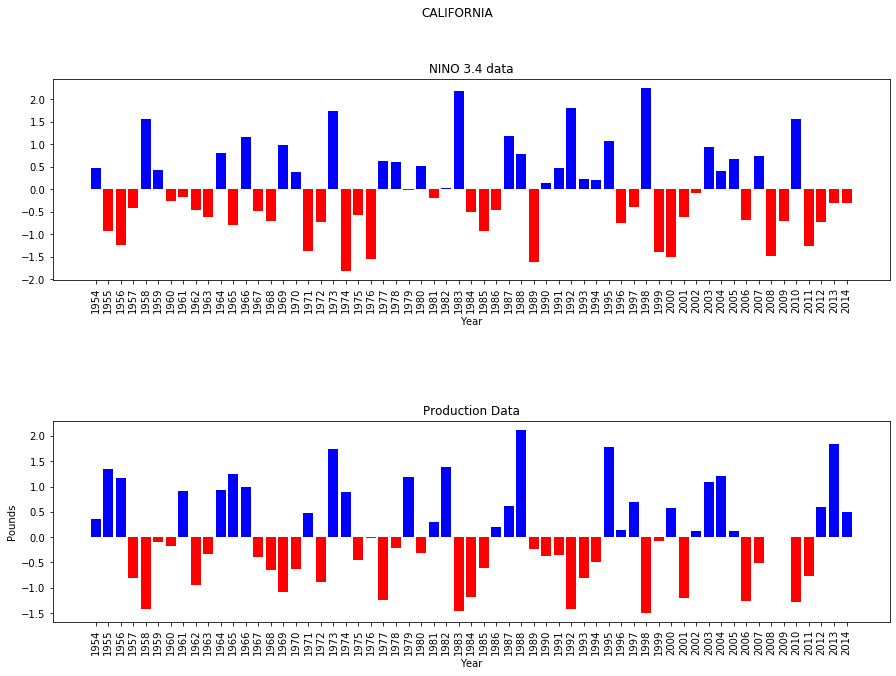

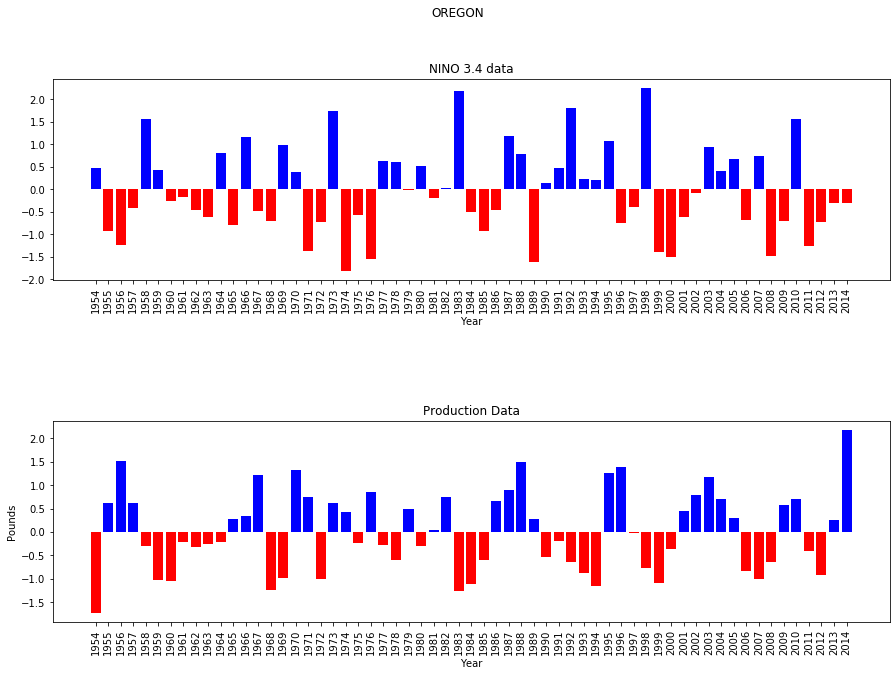

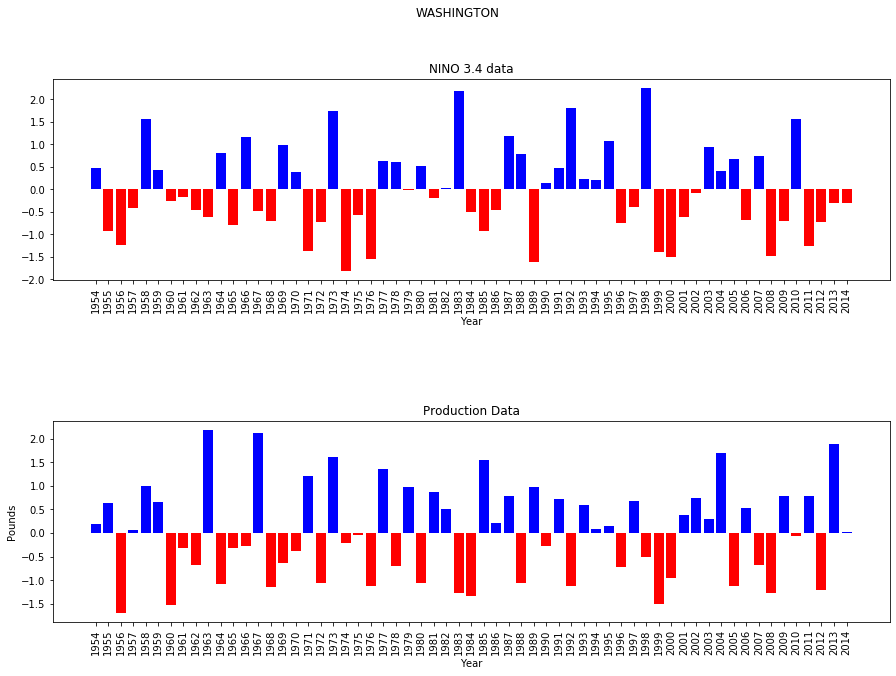

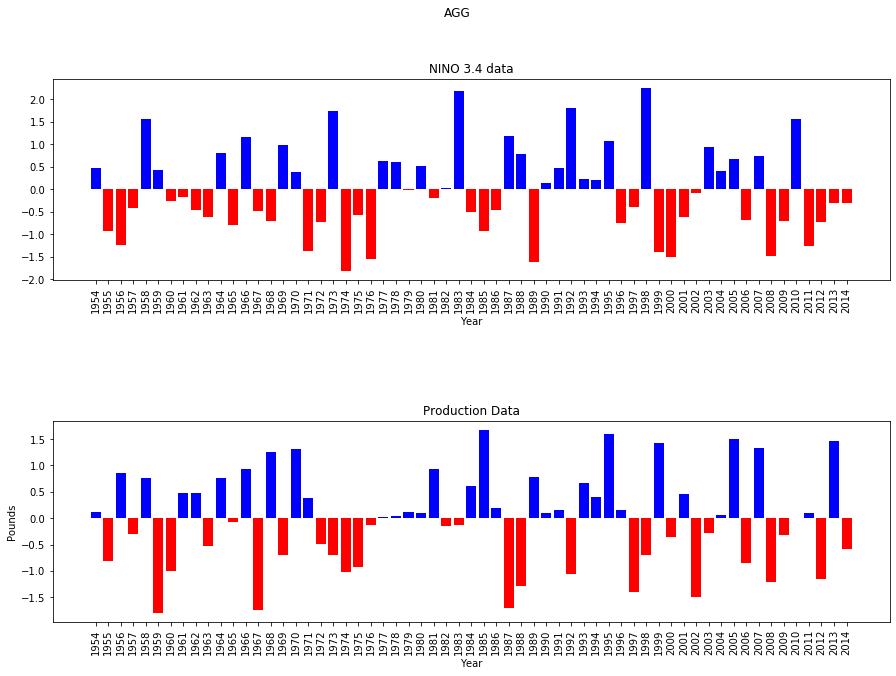

In [150]:
def nino_bar(state, use_scaled_data = True):
    if use_scaled_data:
        nino34_col_name = 'scaled_val'
    else:
        nino34_col_name = 'Val'
        
        
    fish_data = detrend_prod_df_w_lag[state]
    fish_data = detrend_prod_df_w_lag[state]
    fish_year = detrend_prod_df_w_lag['Year'].values
    fish_col = ['r' if v < 0 else 'b' for v in fish_data]

    nino34_data = nino34_df_w_lag[nino34_col_name].values
    nino34_year = nino34_df_w_lag['Year'].values
    nino34_col = ['r' if v < 0 else 'b' for v in nino34_data]
        
#     nino4_data = detrend_nino4_df_w_lag["Val"].values 
#     nino4_year = detrend_nino4_df_w_lag['Year'].values 
#     nino4_col = ['r' if v < 0 else 'b' for v in nino4_data]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    fig.subplots_adjust(wspace=0.7, hspace=0.7)
    
    
    axes[0].bar(nino34_year, nino34_data, color = nino34_col)
#     axes[1].bar(nino4_year, nino4_data, color = nino4_col)
    axes[1].bar(fish_year, fish_data, color = fish_col, align='center')
    
    
    axes[0].title.set_text('NINO 3.4 data')
#     axes[1].title.set_text('NINO 4 Data')
    axes[1].title.set_text('Production Data')
    
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("")
    
#     axes[1].set_xlabel("Year")
#     axes[1].set_ylabel("")
    
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Pounds")

    axes[0].xaxis.set_ticks(nino34_year)
#     axes[1].xaxis.set_ticks(nino4_year)
    axes[1].xaxis.set_ticks(fish_year)
    
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)
        
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)
        
#     for tick in axes[2].get_xticklabels():
#         tick.set_rotation(90)

    fig.suptitle(state)

    plt.show()
    
state_lst = ['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON', 'AGG']
for state in state_lst:
    nino_bar(state)

# Part II - Local Environmental Indicators

In [191]:
rcParams['lines.markersize'] = 5
df2 = pd.read_csv("data/Dataset.csv")

df2 = df2.set_index("Year").T

features = ['PDO_Winter', 'PDO_Summer', 'ONI', '46050 SST', 'Upper 20m T_Winter',
       'Upper 20m T_Summer', 'Deep temperature', 'Deep salinity',
       'Copepod richness anomaly', 'N. copepod biomass anomaly',
       'S. copepod biomass anomaly', 'Biological transition',
       'Ichthyoplankton biomass', 'Ichthyoplankton community index',
       'Chinook salmon juvenile', 'Coho salmon juvenile', 'Upwelling Anomaly',
       'Length of Upwelling Season', 'SST NH-5', 'Copepod Community Index']

targets = ['Washington Chinook', 'Washington Coho', 'Oregon Coho',
       'Oregon Chinook']

# convert object to df

for t in targets:
    df2[t] = df2[t].apply(lambda x: float(x.replace(",", '')))
        
for f in features:
    df2[f] = df2[f].astype(float)
    
df2["AGG"] = df2[['Washington Chinook', 'Washington Coho', 'Oregon Coho', 'Oregon Chinook']].sum(axis = 1)

targets = ['Washington Chinook', 'Washington Coho', 'Oregon Coho', 'Oregon Chinook', 'AGG']



features_vocab = { f:i for i, f in enumerate(features)}
features_vocab.update({ i:f for i, f in enumerate(features)})

targets_vocab = { f:i for i, f in enumerate(targets)}
targets_vocab.update({ i:f for i, f in enumerate(targets)})


# Adding scaled data
column_vocab = {i:col_name for i, col_name in enumerate(df2.columns)}
column_vocab.update( {col_name:i for i, col_name in enumerate(df2.columns)} )

data_scaled = StandardScaler().fit_transform(df2)

for col in df2.columns:
    df2[col + "_scaled"] = data_scaled[:, column_vocab[col]]

    
df2.head()

Year,PDO_Winter,PDO_Summer,ONI,46050 SST,Upper 20m T_Winter,Upper 20m T_Summer,Deep temperature,Deep salinity,Copepod richness anomaly,N. copepod biomass anomaly,...,Coho salmon juvenile_scaled,Upwelling Anomaly_scaled,Length of Upwelling Season_scaled,SST NH-5_scaled,Copepod Community Index_scaled,Washington Chinook_scaled,Washington Coho_scaled,Oregon Coho_scaled,Oregon Chinook_scaled,AGG_scaled
1998,5.07,-0.37,1.12,13.66,12.27,10.38,8.59,33.54,4.54,-0.76,...,-1.304367,0.034466,0.718056,-0.173480,1.706139,-1.737086,-1.536473,-1.033174,-0.567838,-1.672104
1999,-1.75,-5.13,-1.07,13.00,10.31,10.13,7.63,33.86,-2.58,0.04,...,0.289631,1.298203,1.331031,-0.573121,-0.941468,-1.428354,-1.359824,-0.429925,-1.048436,-1.596702
2000,-4.17,-3.58,-1.07,12.54,10.12,10.19,7.74,33.78,-3.41,0.15,...,-0.359471,-0.808026,-1.033300,-0.645782,-0.906631,-1.554195,0.125752,0.801462,-0.362118,-0.648870
2001,1.86,-4.22,-0.40,12.56,10.22,9.77,7.56,33.86,-1.03,0.15,...,0.766187,0.647187,-0.070054,-0.754775,-0.802120,-0.425817,0.960373,1.529738,0.865713,0.740109
2002,-1.73,-0.26,0.18,12.30,10.08,8.98,7.46,33.85,-1.12,0.29,...,0.421095,0.111056,1.900222,-2.262509,-1.133071,0.381052,0.355870,1.049887,1.607448,1.097225


In [192]:
year_lag = 1
# Extract input and output data
x = df2[[f+"_scaled" for f in features]].values[:-year_lag, :]
y = df2[[t+"_scaled" for t in targets]].values[year_lag:, :]

x_year_range = df2.index.values[:-year_lag]
y_year_range = df2.index.values[year_lag:]

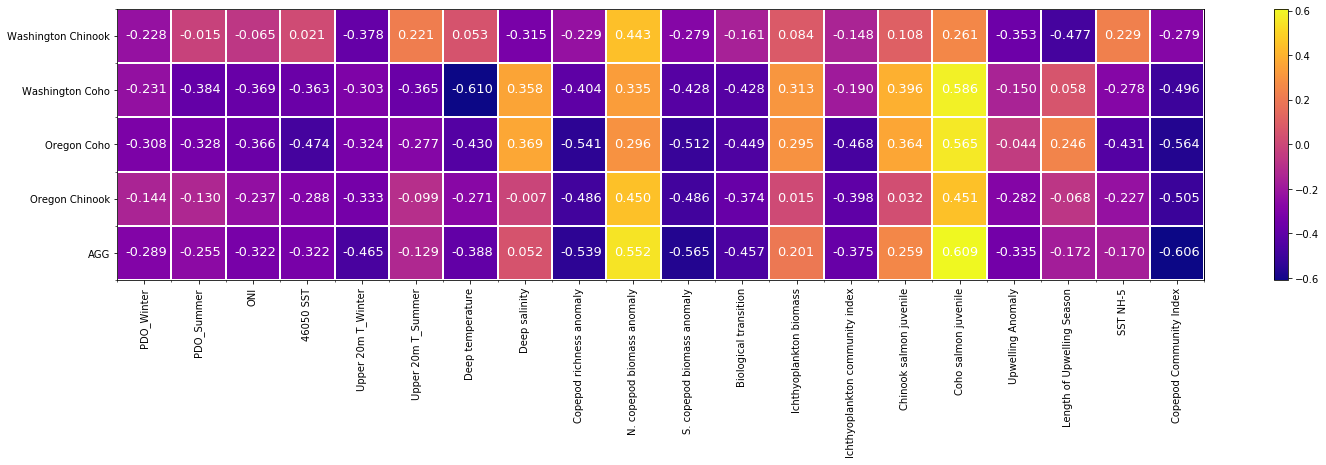

In [162]:
target_feature_corr_dict = {}
tmp_dict = {}

for f in features:
    data_arr = []
    for t in targets:

        x_val = x[:, features_vocab[f]]
        y_val = y[:, targets_vocab[t]]

        corr, p_value = pearsonr(x_val, y_val)

        data_arr.append([corr, p_value])


    target_feature_corr_dict[f] = data_arr
    tmp_dict[f] = [r[0] for r in data_arr]


corr_df = pd.DataFrame(tmp_dict)
corr_df.index = targets

# corr_df.head()

corr_mat = corr_df.values

plt.figure(figsize=(25,5))
plt.imshow(corr_mat, interpolation='none', cmap='plasma')

ax = plt.gca();

len_y, len_x = corr_df.shape

x_tick_mark = np.arange(len_x)
y_tick_mark = np.arange(len_y)

plt.xticks(x_tick_mark, corr_df.columns, rotation=90)
plt.yticks(y_tick_mark, corr_df.index)

ax.set_xticks(np.arange(-.5, len_x, 1), minor=True);
ax.set_yticks(np.arange(-.5, len_y, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

for i in range(len_x):
    for j in range(len_y):
#         print(i, '-',j)
        plt.text(i-0.35,j+0.05, "%.3f"%corr_mat[j][i], color='w', fontsize=13)


plt.colorbar()

plt.show()

### Filtered Corr Map

In [163]:
corr_mat_significant = corr_mat.copy()

len_y, len_x = corr_df.shape

for i in range(len_x):
    for j in range(len_y):
        if abs(corr_mat_significant[j][i]) < 0.4:
            corr_mat_significant[j][i] = np.nan

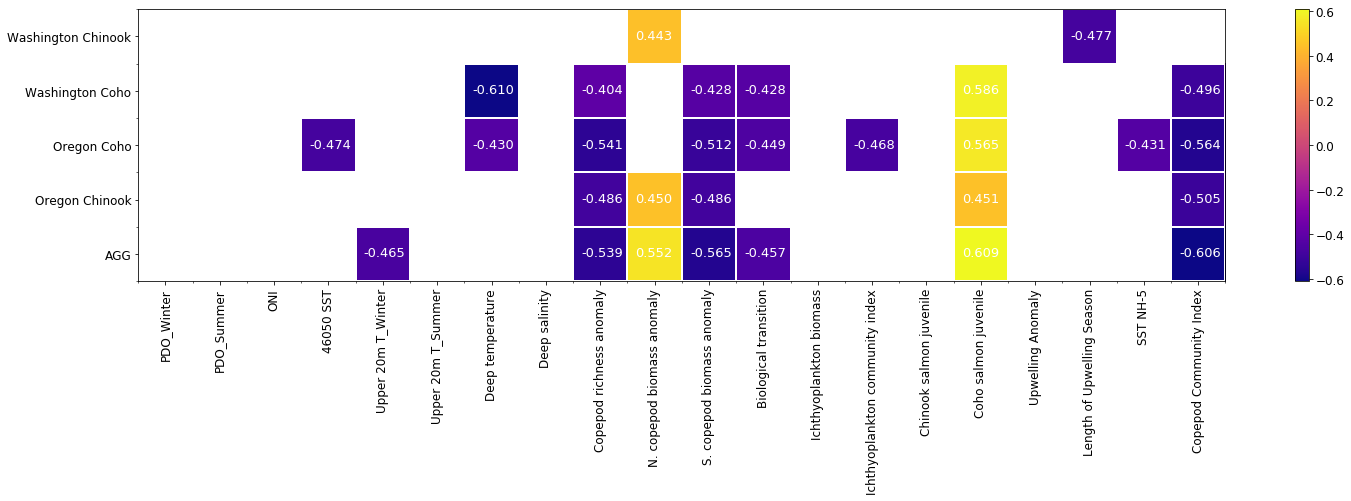

In [282]:
plt.figure(figsize=(25,5))
plt.imshow(corr_mat_significant, interpolation='none', cmap='plasma')

ax = plt.gca();

len_y, len_x = corr_df.shape

x_tick_mark = np.arange(len_x)
y_tick_mark = np.arange(len_y)

plt.xticks(x_tick_mark, corr_df.columns, rotation=90)
plt.yticks(y_tick_mark, corr_df.index)

ax.set_xticks(np.arange(-.5, len_x, 1), minor=True);
ax.set_yticks(np.arange(-.5, len_y, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

for i in range(len_x):
    for j in range(len_y):
#         print(i, '-',j)
        plt.text(i-0.35,j+0.05, "%.3f"%corr_mat[j][i], color='w', fontsize=13)


plt.colorbar()

plt.show()

In [165]:
def plot_filtered_correlation(target):
    indicator_corr_dict = corr_df.T[target].to_dict()
    indicator_corr_dict = { k:v for k, v in indicator_corr_dict.items() if abs(v) > 0.4 }
    sorted_indicator_corr_dict = sorted(indicator_corr_dict.items(), key = lambda x:x[1], reverse=True)

    sorted_indicator_lst = [k for k,v in sorted_indicator_corr_dict]
    sorted_corr_val_lst = [v for k,v in sorted_indicator_corr_dict]

    bar_col = ['r' if i < 0 else 'b' for i in sorted_corr_val_lst]

    tmp_xtick = range(len(sorted_indicator_corr_dict))
    plt.barh(tmp_xtick, sorted_corr_val_lst, color = bar_col)

    plt.yticks(tmp_xtick, sorted_indicator_lst)
    plt.title("Indicators with Significant Correlation for %s" % target)

    ylabel("Indicator")
    xlabel("Correlation Score")
    plt.show()

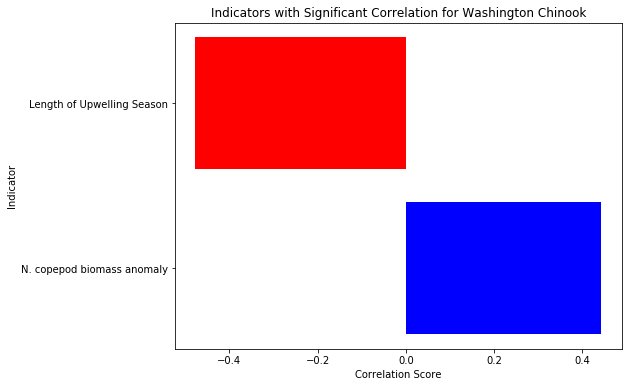

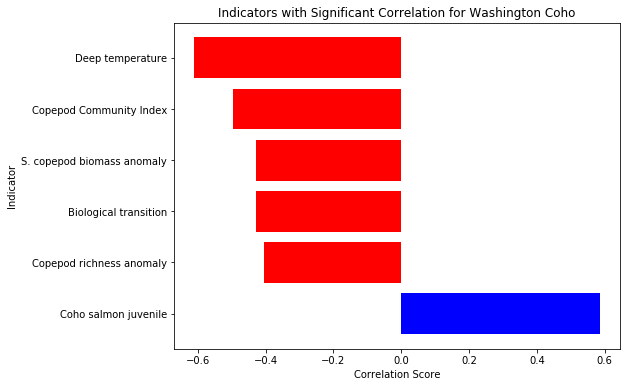

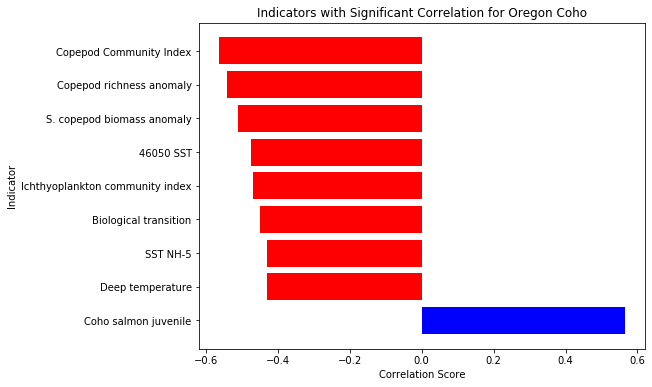

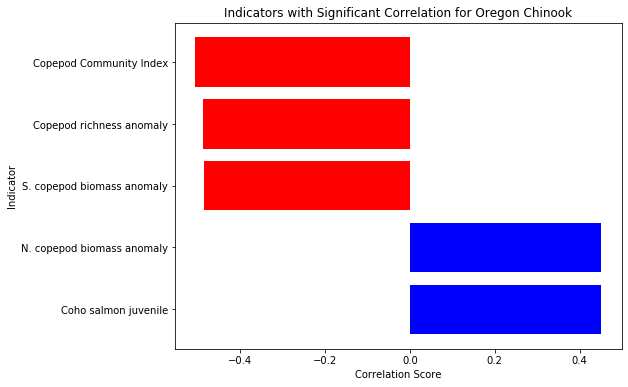

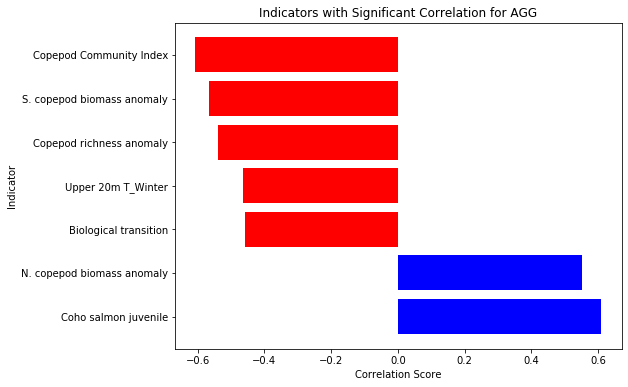

In [166]:
for t in targets:
    plot_filtered_correlation(t)

In [167]:
def evaluate_relation(feature, target):
    year_val = df2.index

    # Extract feature and target
    x_train = x[:, features_vocab[feature]].reshape(-1,1)
    y_train = y[:, targets_vocab[target]]

    simple_model = LinearRegression()
    simple_model.fit(x_train, y_train)

    r_sq = simple_model.score(x_train, y_train)

    intercept = simple_model.intercept_

    coef = simple_model.coef_

    y_pred = simple_model.predict(x_train)

    print("Linear model y = %.3f x + %.3f | r_sq = %.3f"%(coef, intercept, r_sq))


    plt.figure(figsize=(10,5))
    plt.scatter(x_train, y_train)

    plt.plot(x_train, y_pred, color ='red')

    plt.xlabel(feature + " (scaled)")
    plt.ylabel(target)

    plt.legend(["y = %.3f x + %.3f | r_sq = %.3f"%(coef, intercept, r_sq), "data"])

    plt.show()

Linear model y = -0.579 x + 0.058 | r_sq = 0.372


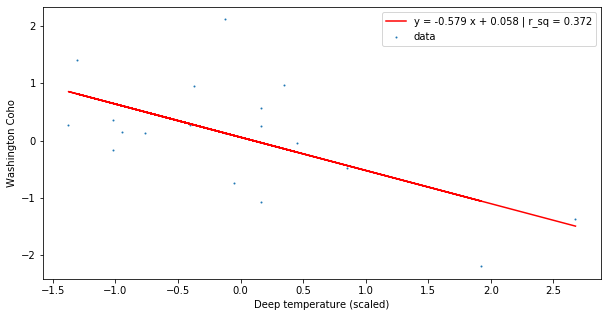

Linear model y = 0.581 x + 0.037 | r_sq = 0.343


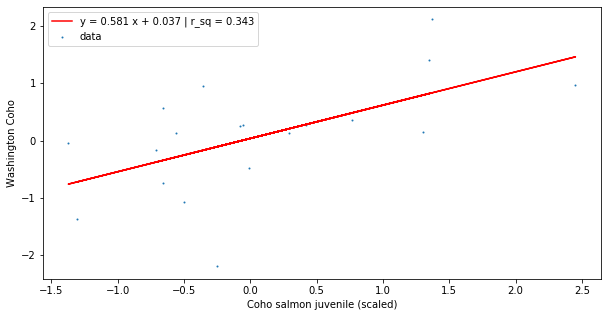

Linear model y = -0.529 x + 0.042 | r_sq = 0.293


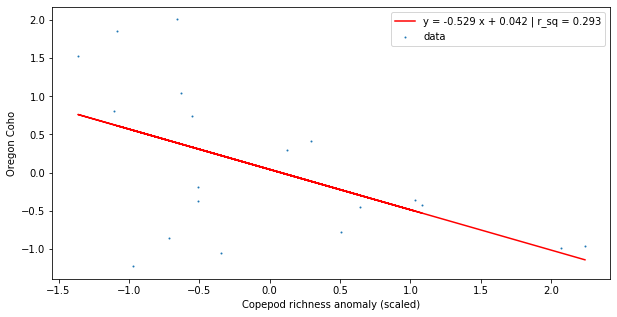

Linear model y = -0.509 x + 0.030 | r_sq = 0.263


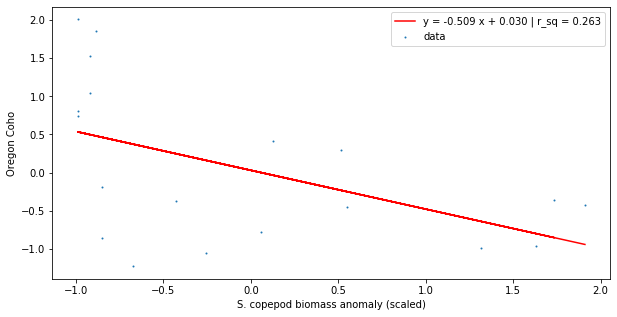

Linear model y = 0.581 x + 0.010 | r_sq = 0.319


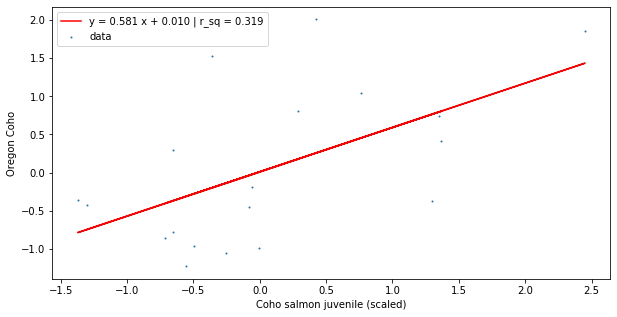

Linear model y = -0.562 x + 0.026 | r_sq = 0.318


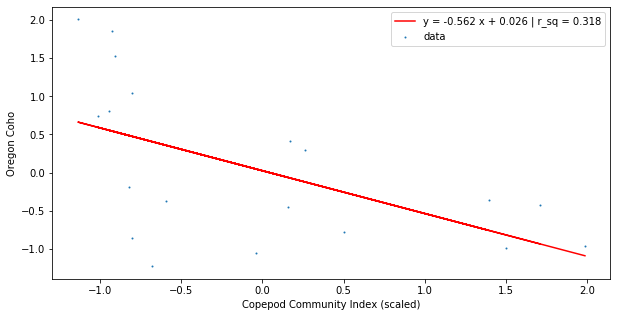

Linear model y = -0.513 x + 0.004 | r_sq = 0.255


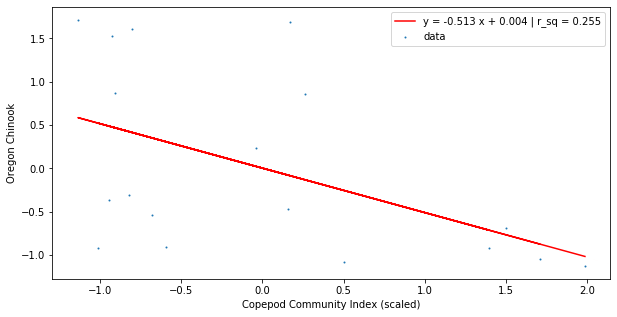

Linear model y = -0.501 x + 0.076 | r_sq = 0.291


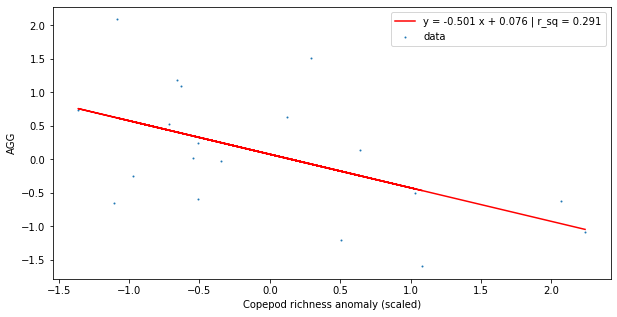

Linear model y = 0.539 x + 0.048 | r_sq = 0.305


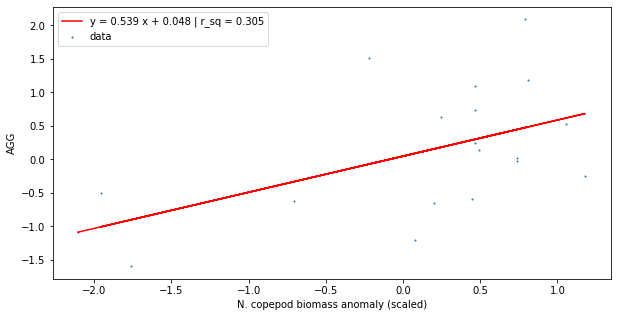

Linear model y = -0.533 x + 0.063 | r_sq = 0.319


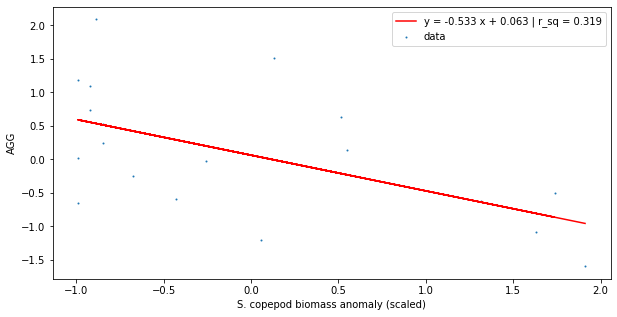

Linear model y = 0.596 x + 0.043 | r_sq = 0.371


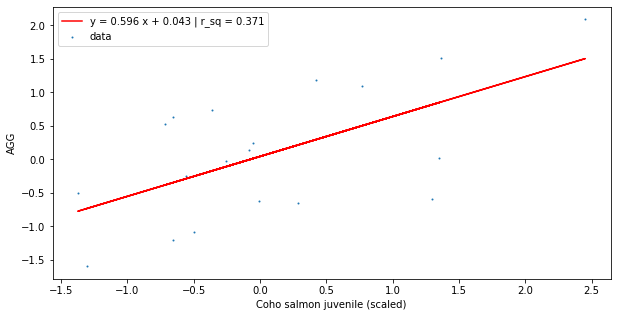

Linear model y = -0.574 x + 0.059 | r_sq = 0.367


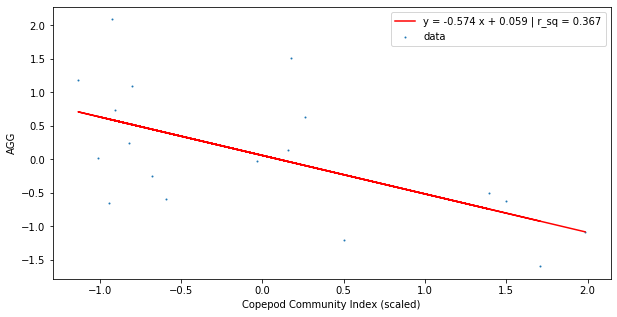

In [168]:
for t, row in enumerate(corr_mat):
    for f, val in enumerate(row):
        target_label = targets_vocab[t]
        feature_label = features_vocab[f]
#         print(target_label, ', ', feature_label)       
        
        if abs(val) > 0.5:
#             print(feature_label)
            evaluate_relation(feature_label, target_label)

### Dimension Reduction with PCA

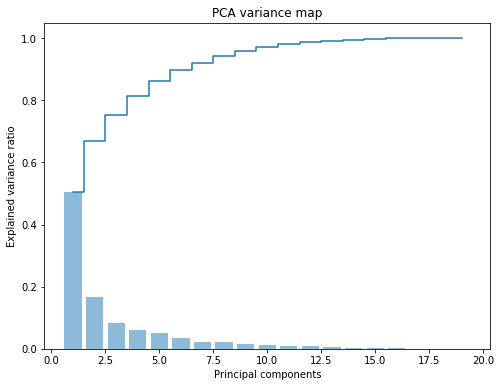

In [169]:
num_component = 3

pca_all = PCA()

principalComponents_all = pca_all.fit_transform(x)

var_ratio_lst = pca_all.explained_variance_ratio_
var_ratio_len = len(var_ratio_lst)
plt.bar(range(1,var_ratio_len+1), var_ratio_lst, align='center', alpha=0.5)
plt.step(range(1,var_ratio_len+1), np.cumsum(var_ratio_lst), where='mid')
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.title("PCA variance map")
plt.show()

In [170]:
num_component = 3

pca = PCA(n_components=num_component)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ["p_component %d" % (i+1) for i in range(num_component)])

In [237]:
def linear_regression_plot(x_train, y_train, title = 'Title'):
    
    x_train = sm.add_constant(x_train)
    model = sm.OLS(y_train, x_train)

    results = model.fit()
    
    mse_tot = results.mse_total
    r_sq = results.rsquared
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

    axes[0].scatter(x_year_range, y_train)
    axes[0].plot(results.fittedvalues, color = 'r')
    axes[0].title.set_text('Actual vs Prediction')
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("Pounds")
    
    axes[0].legend(["Linear Regression Model | r_sq = %.3f"%(r_sq), "data"])
    
    fig.suptitle(title, fontsize=16,y=1.02)

    axes[1].scatter(x_year_range, results.resid)
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].title.set_text('Residual')
    axes[1].legend(["Total mean squared error = %.3f"%(mse_tot)])
    axes[1].set_xlabel("Year")

    fig.tight_layout()
    plt.show()
    
    return model, results

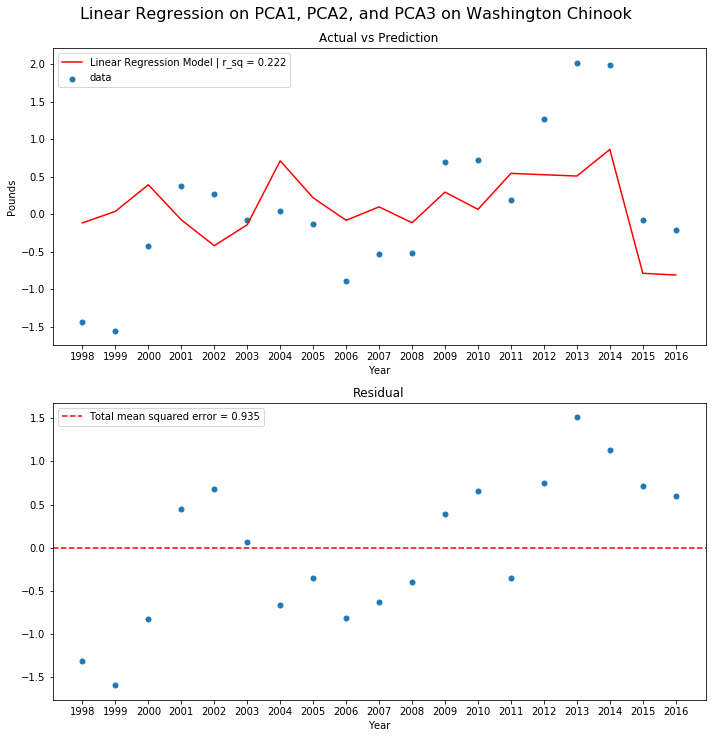

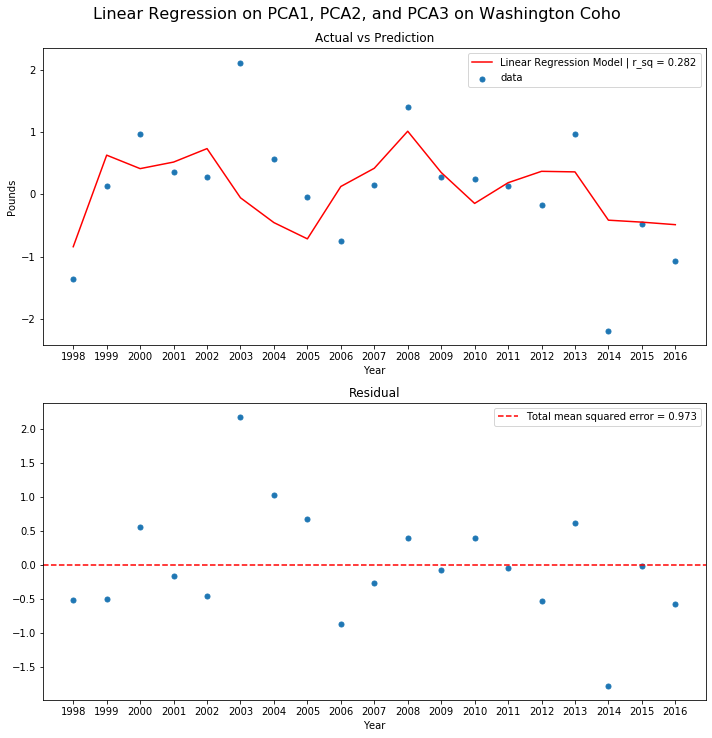

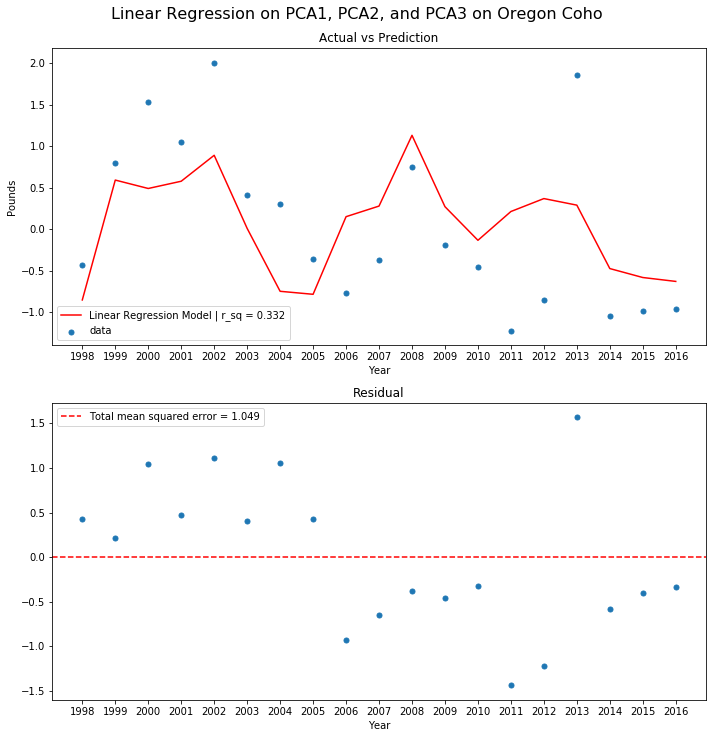

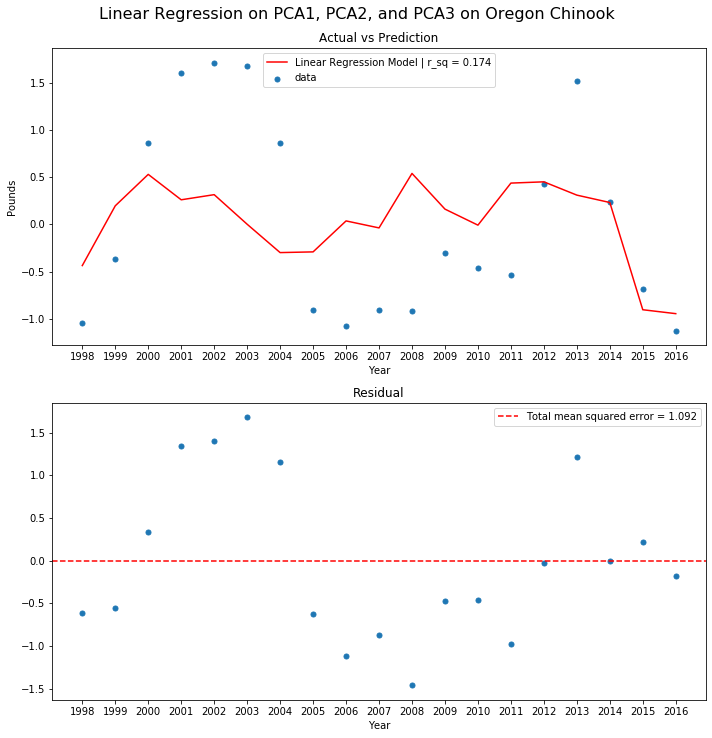

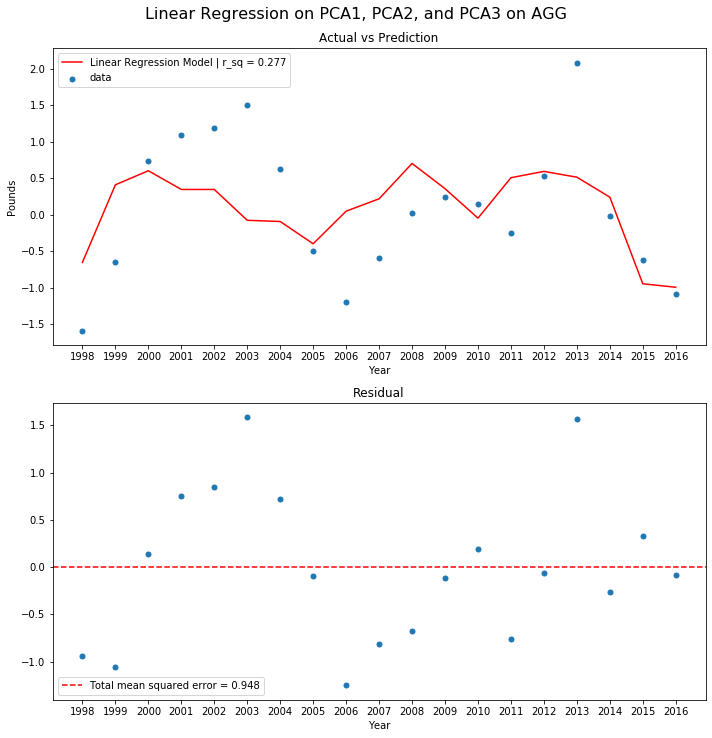

In [238]:
for t in targets:
    # Extract feature and target
    x_train = principalComponents
    y_train = y[:, targets_vocab[t]]
    mod, res = linear_regression_plot(x_train, y_train, title = "Linear Regression on PCA1, PCA2, and PCA3 on " + t)

# Cross validation with 3 PCA

In [280]:
def cross_val_3pca(t, n_run = 20):

    corr_arr_tmp = corr_df.T[t].to_dict()
    corr_arr_tmp = sorted(corr_arr_tmp.items(), key = lambda x: abs(x[1]))
    sorted_idx_arr = [features_vocab[i] for i, v in corr_arr_tmp]
    
    X_data = principalComponents
    y_data = y[:, targets_vocab[t]]

    rkf = RepeatedKFold(n_splits=5, n_repeats=n_run, random_state=312412)

    plt.figure(figsize=(13,5))

    mse_lst = []

    pred_dict = {year:[] for year in x_year_range}

    plt.scatter(x_year_range, y_data, color = 'b')

    for train_index, test_index in rkf.split(X_data):
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]

        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)
        
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        y_pred = results.predict(X_test)

        for idx, year in enumerate(x_year_range[test_index]):
            pred_dict[year].append(y_pred[idx])

        residual = (y_test - y_pred)**2
        mse = np.mean(residual)

        mse_lst.append(mse)

        # plot
        plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85))
    #     print(x_year_range[test_index])
    #     plt.plot(results.fittedvalues, color = 'r')

    print("Average mse of %d run through is %.3f" % (n_run, np.mean(mse_lst)))

    mean_pred_lst = [np.mean(pred_dict[year]) for year in x_year_range]
    median_pred_lst = [np.median(pred_dict[year]) for year in x_year_range]

    
    plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85), label = 'Prediction')
    # print(x_year_range[test_index])
    plt.scatter(x_year_range, y_data, color = 'b', label = 'Actual')

    plt.scatter(x_year_range, mean_pred_lst, color = (0.9, 0.1, 0.1), label = 'Mean Prediction')
    plt.scatter(x_year_range, median_pred_lst, color = (0.1, 0.9, 0.2, 0.7), label = 'Median Prediction')
    rcParams['lines.markersize'] = 5
    
    plt.legend()
    
    plt.title('%s Actual vs Prediction \n cross validation %d times \n (PCA)' % (t, n_run))
    plt.xlabel("Year")
    plt.ylabel("Pounds")
    plt.show()

Average mse of 20 run through is 1.271


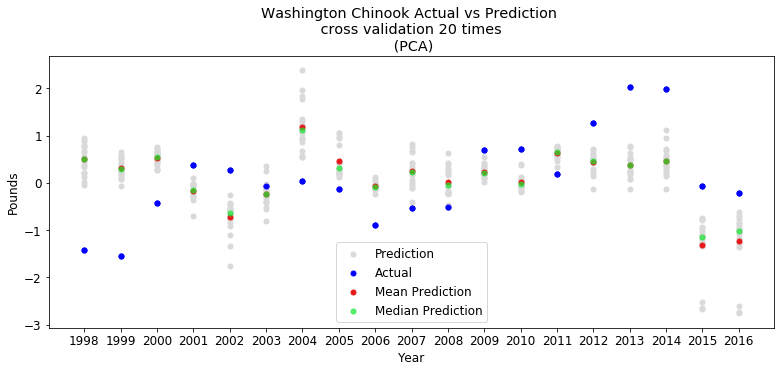

Average mse of 20 run through is 1.213


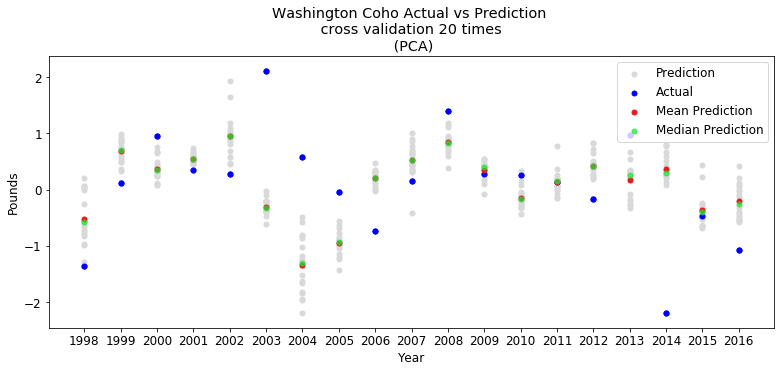

Average mse of 20 run through is 1.191


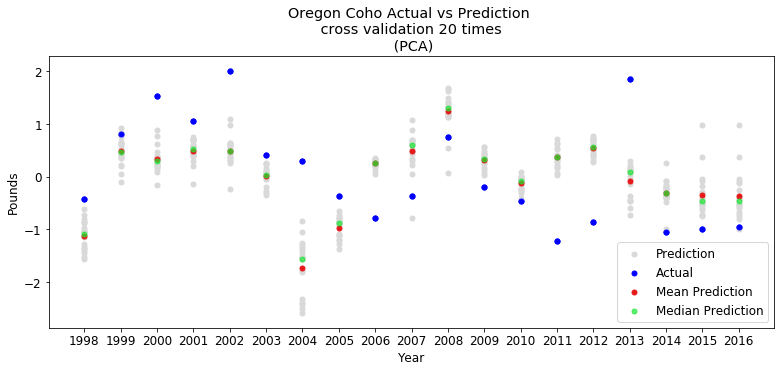

Average mse of 20 run through is 1.518


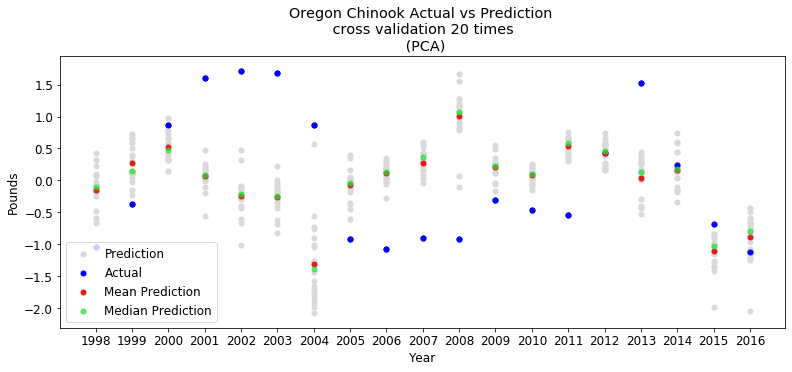

Average mse of 20 run through is 1.077


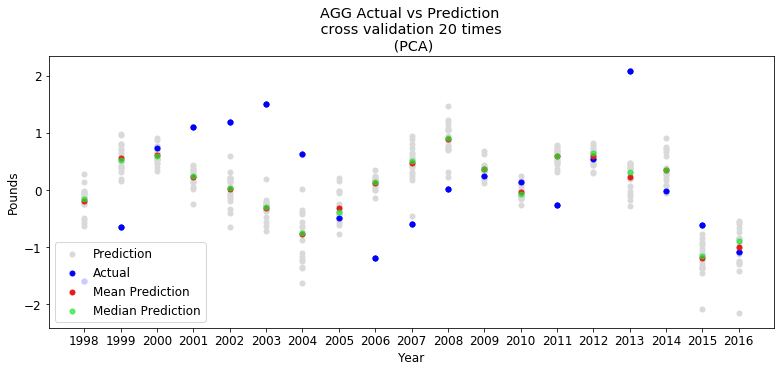

In [281]:
for t in targets:
    cross_val_3pca(t)

In [286]:
def cross_val2(t, ml_model, n_run = 20):

    corr_arr_tmp = corr_df.T[t].to_dict()
    corr_arr_tmp = sorted(corr_arr_tmp.items(), key = lambda x: abs(x[1]))
    sorted_idx_arr = [features_vocab[i] for i, v in corr_arr_tmp]
    
    X_data = x[:, sorted_idx_arr[:9]]
    y_data = y[:, targets_vocab[t]]

    rkf = RepeatedKFold(n_splits=5, n_repeats=n_run, random_state=312412)

    plt.figure(figsize=(13,5))

    mse_lst = []

    pred_dict = {year:[] for year in x_year_range}

    plt.scatter(x_year_range, y_data, color = 'b')

    for train_index, test_index in rkf.split(X_data):
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]

        model = ml_model
        results = model.fit(X_train, y_train)

        y_pred = results.predict(X_test)

        for idx, year in enumerate(x_year_range[test_index]):
            pred_dict[year].append(y_pred[idx])

        residual = (y_test - y_pred)**2
        mse = np.mean(residual)

        mse_lst.append(mse)

        # plot
        plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85))
    #     print(x_year_range[test_index])
    #     plt.plot(results.fittedvalues, color = 'r')

    print("Average mse of %d run through is %.3f" % (n_run, np.mean(mse_lst)))

    mean_pred_lst = [np.mean(pred_dict[year]) for year in x_year_range]
    median_pred_lst = [np.median(pred_dict[year]) for year in x_year_range]


    plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85), label = 'Prediction')
    # print(x_year_range[test_index])
    plt.scatter(x_year_range, y_data, color = 'b', label = 'Actual')

    plt.scatter(x_year_range, mean_pred_lst, color = (0.9, 0.1, 0.1), label = 'Mean Prediction')
    plt.scatter(x_year_range, median_pred_lst, color = (0.1, 0.9, 0.2, 0.7), label = 'Median Prediction')
    rcParams['lines.markersize'] = 5
    
    plt.legend()

    plt.title('%s Actual vs Prediction \n cross validation %d times \n(Ensemble models with Grid Search using PCA)' % (t, n_run))
    plt.xlabel("Year")
    plt.ylabel("Pounds")
    plt.show()

In [304]:
def cross_val3(t, ml_model, n_run = 20):

    corr_arr_tmp = corr_df.T[t].to_dict()
    corr_arr_tmp = sorted(corr_arr_tmp.items(), key = lambda x: abs(x[1]))
    sorted_idx_arr = [features_vocab[i] for i, v in corr_arr_tmp]
    
    X_data = principalComponents
    y_data = y[:, targets_vocab[t]]

    rkf = RepeatedKFold(n_splits=5, n_repeats=n_run, random_state=312412)

    plt.figure(figsize=(13,5))

    mse_lst = []

    pred_dict = {year:[] for year in x_year_range}

    plt.scatter(x_year_range, y_data, color = 'b')

    for train_index, test_index in rkf.split(X_data):
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]

        model = ml_model
        results = model.fit(X_train, y_train)

        y_pred = results.predict(X_test)

        for idx, year in enumerate(x_year_range[test_index]):
            pred_dict[year].append(y_pred[idx])

        residual = (y_test - y_pred)**2
        mse = np.mean(residual)

        mse_lst.append(mse)

        # plot
        plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85))
    #     print(x_year_range[test_index])
    #     plt.plot(results.fittedvalues, color = 'r')

    print("Average mse of %d run through is %.3f" % (n_run, np.mean(mse_lst)))

    mean_pred_lst = [np.mean(pred_dict[year]) for year in x_year_range]
    median_pred_lst = [np.median(pred_dict[year]) for year in x_year_range]


    plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85), label = 'Prediction')
    # print(x_year_range[test_index])
    plt.scatter(x_year_range, y_data, color = 'b', label = 'Actual')

    plt.scatter(x_year_range, mean_pred_lst, color = (0.9, 0.1, 0.1), label = 'Mean Prediction')
    plt.scatter(x_year_range, median_pred_lst, color = (0.1, 0.9, 0.2, 0.7), label = 'Median Prediction')
    rcParams['lines.markersize'] = 5
    
    plt.legend()

    plt.title('%s Actual vs Prediction \n cross validation %d times \n(Ensemble models with Grid Search on PCA)' % (t, n_run))
    plt.xlabel("Year")
    plt.ylabel("Pounds")
    plt.show()

#### Approach 1

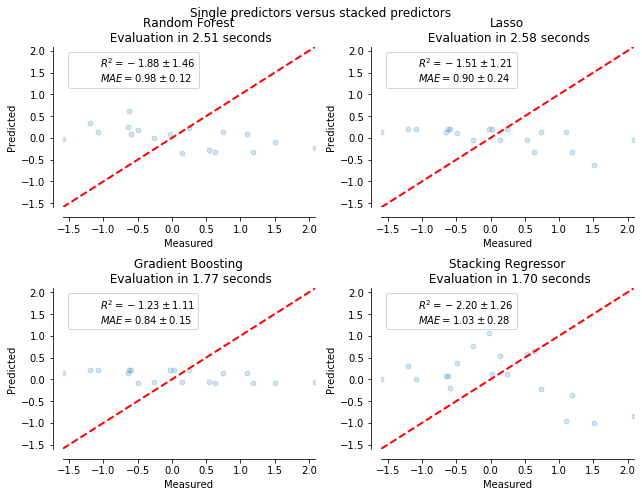

In [193]:
#Example 1: https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py

from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

import matplotlib.pyplot as plt


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)
    

estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Lasso', LassoCV()),
    ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))
]

# stacking_regressor = StackingRegressor(
#     regressors=estimators, meta_regressor=RidgeCV()
# )


stacking_regressor = StackingRegressor(regressors=[svr_lin, lr, ridge], 
                           meta_regressor=svr_rbf)

import time
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_validate, cross_val_predict

corr_arr_tmp = corr_df.T['AGG'].to_dict()
corr_arr_tmp = sorted(corr_arr_tmp.items(), key = lambda x: abs(x[1]))
sorted_idx_arr = [features_vocab[i] for i, v in corr_arr_tmp]

X_data = x[:, sorted_idx_arr[:9]]
y_data = y[:, targets_vocab['AGG']]

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X_data, y_data,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_data, y_data, n_jobs=-1, verbose=0)
    plot_regression_results(
        ax, y_data, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Approach 2: Ensemble of 20 variables & PCA

In [232]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Initializing models

lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
lasso = Lasso(random_state=1)
svr_rbf = SVR(kernel='rbf')
regressors = [svr_lin, lr, ridge, lasso]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=svr_rbf)

params = {'lasso__alpha': [0.1, 1.0, 10.0],
          'ridge__alpha': [0.1, 1.0, 10.0],
          'svr__C': [0.1, 1.0, 10.0],
          'meta_regressor__C': [0.1, 1.0, 10.0, 100.0],
          'meta_regressor__gamma': [0.1, 1.0, 10.0]}

grid = GridSearchCV(estimator=stregr, 
                    param_grid=params, 
                    cv=5,
                    refit=True)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.6, random_state=42)

grid.fit(X_test, y_test)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: -0.912613 using {'lasso__alpha': 1.0, 'meta_regressor__C': 0.1, 'meta_regressor__gamma': 0.1, 'ridge__alpha': 10.0, 'svr__C': 0.1}


Average mse of 20 run through is 1.038


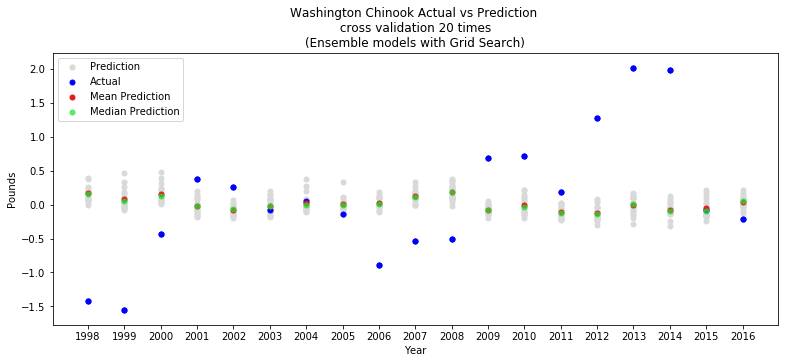

Average mse of 20 run through is 1.032


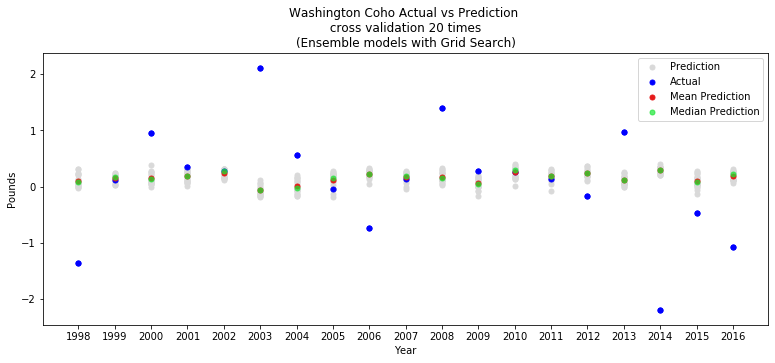

Average mse of 20 run through is 1.259


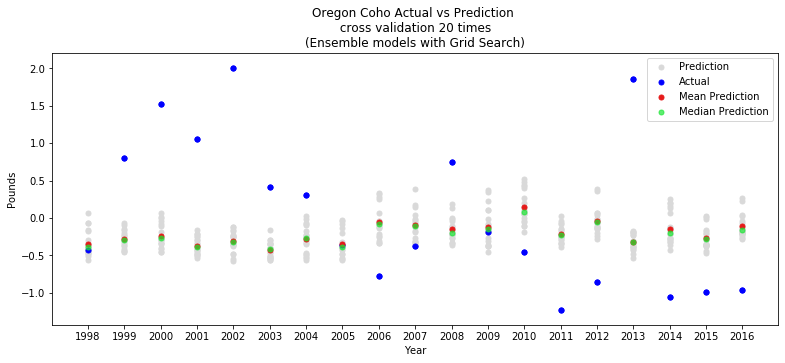

Average mse of 20 run through is 1.486


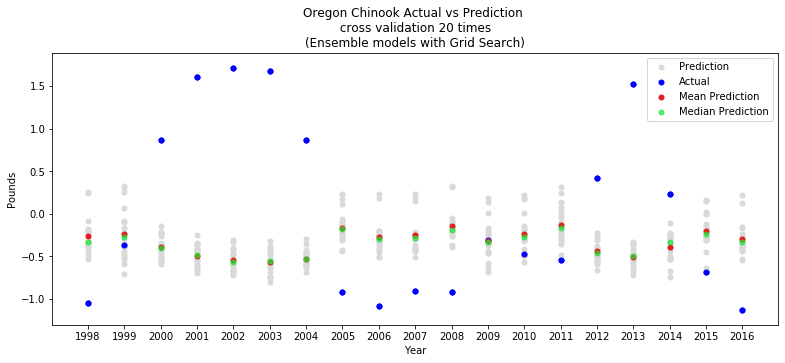

Average mse of 20 run through is 1.131


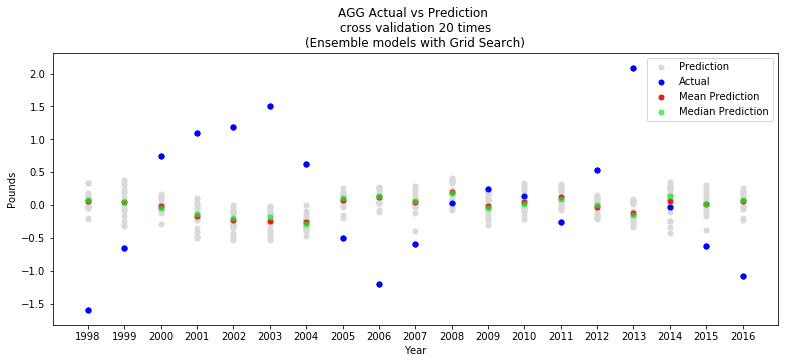

In [278]:
rcParams['lines.markersize'] = 5

best_grid = grid.best_estimator_
for t in targets:
    cross_val2(t,best_grid)

Average mse of 20 run through is 0.964


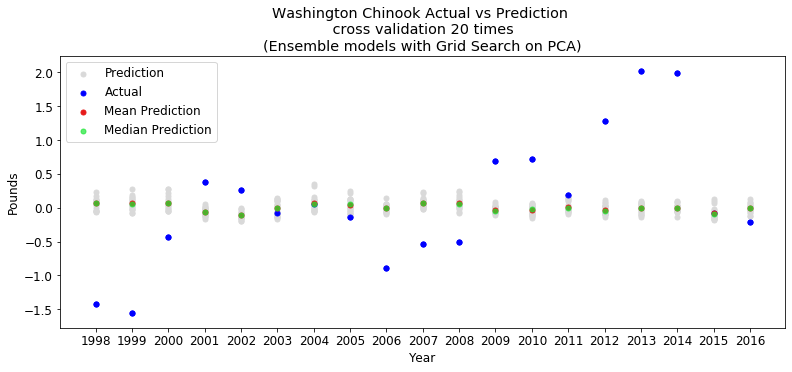

Average mse of 20 run through is 0.952


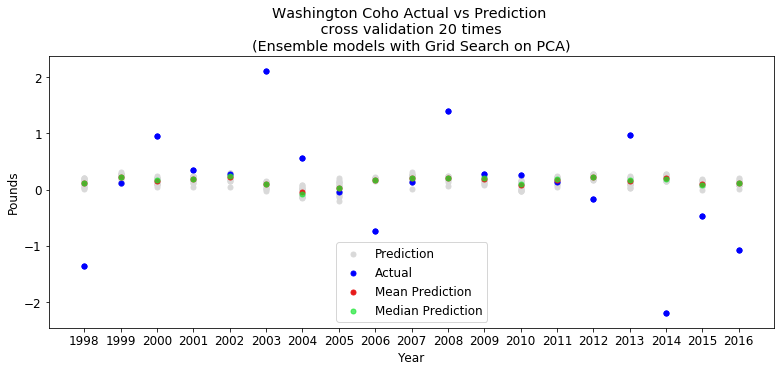

Average mse of 20 run through is 1.179


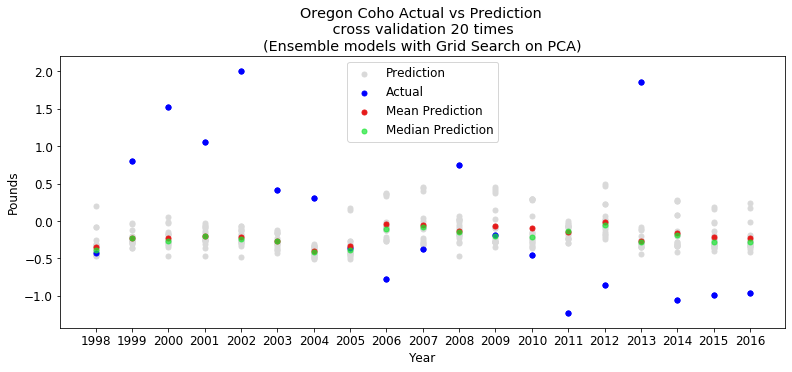

Average mse of 20 run through is 1.352


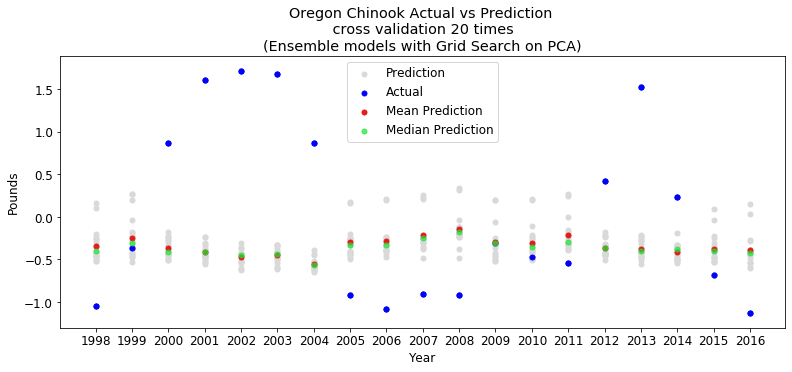

Average mse of 20 run through is 1.006


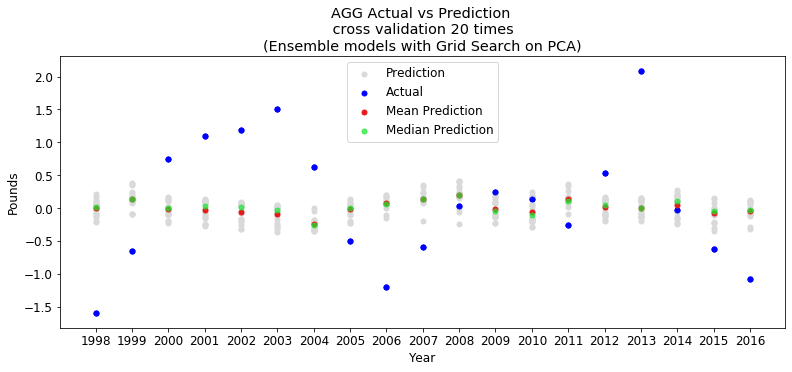

In [305]:
for t in targets:
    cross_val3(t,best_grid)

#### Approach 3

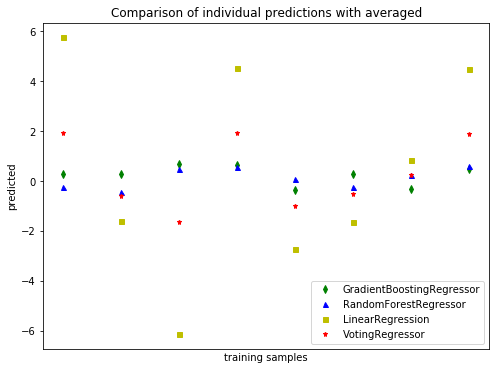

In [208]:
#Example 3: https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor 

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=100)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg1.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)
ereg.fit(X_train, y_train)


plt.figure()
plt.plot(reg1.predict(X_test), 'gd', label='GradientBoostingRegressor')
plt.plot(reg2.predict(X_test), 'b^', label='RandomForestRegressor')
plt.plot(reg3.predict(X_test), 'ys', label='LinearRegression')
plt.plot(ereg.predict(X_test), 'r*', label='VotingRegressor')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()

Average mse of 20 run through is 2.332


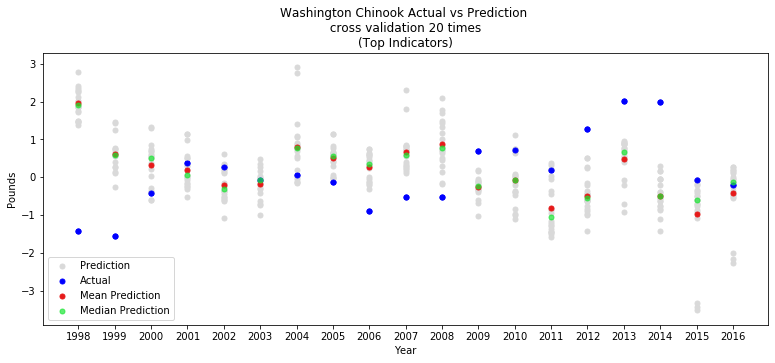

Average mse of 20 run through is 1.939


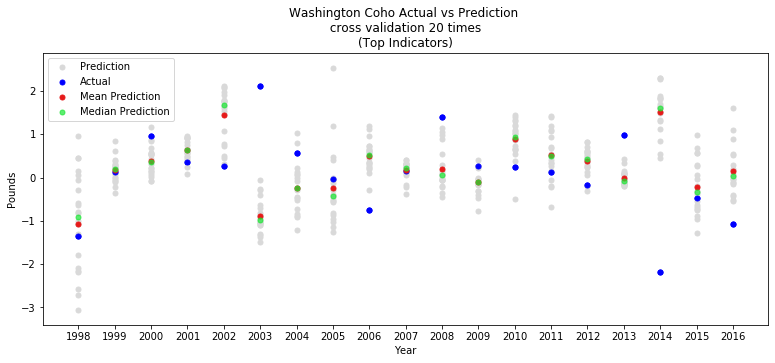

Average mse of 20 run through is 1.547


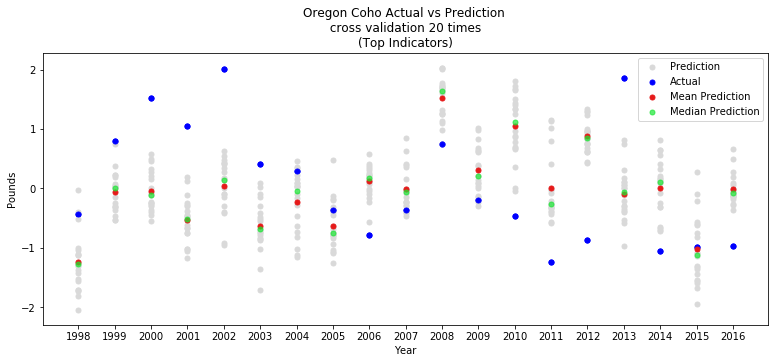

Average mse of 20 run through is 2.524


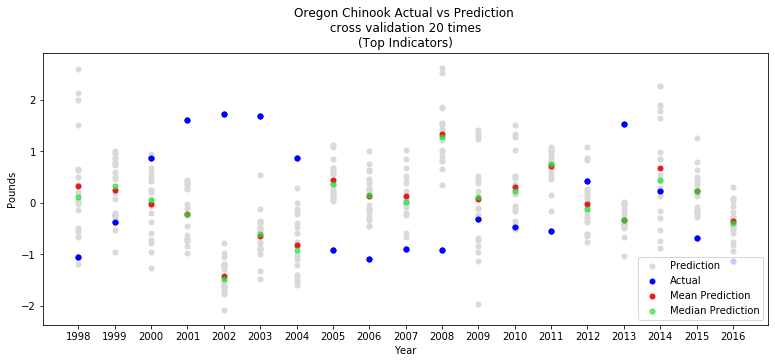

Average mse of 20 run through is 1.953


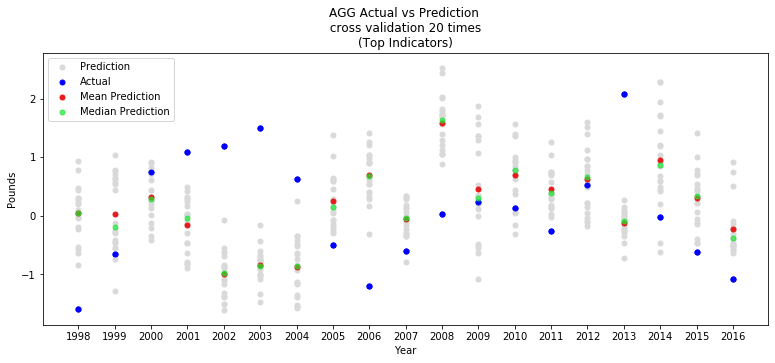

In [215]:
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=100)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])

model = ereg

for t in targets:
    cross_val2(t,model)

#### Approach 4

In [218]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [229]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_predict = base_model.predict(X_test)
base_r2 = r2_score(y_test, base_predict)
base_mse = mean_squared_error(y_test, base_predict)
print('MSE: {:0.4f}.'.format(base_mse))
print('R2 = {:0.2f}.'.format(base_r2))

best_random = rf_random.best_estimator_
best_predict = best_random.predict(X_test)
best_r2 = r2_score(y_test, best_predict)
best_mse = mean_squared_error(y_test, best_random.predict(X_test))
print('MSE: {:0.4f}.'.format(best_mse))
print('R2 = {:0.2f}.'.format(best_r2))

#print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

MSE: 1.0757.
R2 = -0.09.
MSE: 1.1206.
R2 = -0.13.


#### Approach 5

In [295]:
#https://datascienceplus.com/lasso-regression-in-python/

from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=42)

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
rmse_cv(model_lasso).mean()

/Users/Tung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026021643943636708, tolerance: 0.000757743673120715
  tol, rng, random, positive)
/Users/Tung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012003250593086712, tolerance: 0.000757743673120715
  tol, rng, random, positive)
/Users/Tung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009547420481865743, tolerance: 0.0006821428484507604
  tol, rng, random, positive)


0.722513825005077

#### Approach 6: Non linear model

In [299]:
#https://towardsdatascience.com/machine-learning-with-python-easy-and-robust-method-to-fit-nonlinear-data-19e8a1ddbd49

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000
# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8
# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.2)
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)

for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), 
                          LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)

In [ ]:
# for t in targets:
#     corr_arr_tmp = corr_df.T[t].to_dict()

#     corr_arr_tmp = sorted(corr_arr_tmp.items(), key = lambda x: abs(x[1]))

#     sorted_idx_arr = [features_vocab[i] for i, v in corr_arr_tmp]

#     x_train = x[:, sorted_idx_arr[:9]]
#     y_train = y[:, targets_vocab[t]]

#     mod, res = linear_regression_plot(x_train, y_train, title = "Linear Regression on top 10 correlation " + t)

In [ ]:
# for t in targets:
#     # Extract feature and target
#     x_train = principalComponents[:,0].reshape(-1,1)
#     y_train = y[:, targets_vocab[t]]

#     model = LinearRegression()
#     model.fit(x_train, y_train)

#     r_sq = model.score(x_train, y_train)

#     intercept = model.intercept_

#     coef = model.coef_

#     y_pred = model.predict(x_train)

#     print("r_sq = %.3f"%(r_sq))

#     plt.figure(figsize=(10,5))
#     plt.scatter(x_train, y_train)

#     plt.plot(x_train, y_pred, color ='red')

#     plt.xlabel('PC1')
#     plt.ylabel(t)

#     plt.legend(["y = %.3f x + %.3f | r_sq = %.3f"%(coef, intercept, r_sq), "data"])

#     plt.show()

In [ ]:
# scale_bol = True

# sorted_order = []

# for c_idx, col in enumerate(features):
    
#     x_val = df2['Washington Chinook']#[int(i) for i in df2.index]
    
#     if scale_bol:
#         y_val = x[c_idx]
#     else:
#         y_val = df2[col]
    
#     corr, p_value = pearsonr(x_val, y_val)
    
#     sorted_order.append([c_idx, col, corr, p_value])
    
# sorted_order.sort(key=lambda x: abs(x[2]), reverse=True)
    
# for c_idx, col, corr, p_value in sorted_order:
    
#     x_val = df2.index
    
#     if scale_bol:
#         y_val = x[c_idx]
#     else:
#         y_val = df2[col]
        
#     colors = []
#     for row in y_val:
#         c = "red" if row <= 0 else "blue"
#         colors.append(c)
    
#     plt.bar(x_val, y_val, color = colors)
#     plt.xticks(rotation=90)

#     plt.xlabel("Year")
#     plt.ylabel(col)
#     plt.show()
    
#     print("corr %.3f | p_val %.6f" % (corr, p_value))